In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
import json
from nltk.metrics import agreement,masi_distance,jaccard_distance,binary_distance
from nltk.metrics.agreement import AnnotationTask

from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from skmultilearn.problem_transform import LabelPowerset

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re, string
import sys
import warnings

from sklearn.feature_extraction.text import CountVectorizer
import joblib

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

In [2]:
print('The nltk version is {}.'.format(nltk.__version__))
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.4.
The scikit-learn version is 0.21.3.


## Download data from database

In [3]:
# import the modules
from pymysql import *
import xlwt
import pandas.io.sql as sql
import sys
import argparse

def download_data(start_user, end_user, output_filename):
    # connect the mysql with the python
    con=connect(user="root",password="1234567890",host="localhost",database="backup_notasi", port=3307)

    start_user = start_user
    end_user = end_user
    # read the data
    df=sql.read_sql("SELECT user.username, song.musisi, song.title, song.link, song.path, song.filename, song.lirik, case when annotation.is_sad = 1 THEN 'SAD' ELSE NULL END as SAD, case when annotation.is_happy = 1 THEN 'HAPPY' ELSE NULL END as HAPPY, case when annotation.is_angry = 1 THEN 'ANGRY' ELSE NULL END as ANGRY, case when annotation.is_relaxed = 1 THEN 'RELAXED' ELSE NULL END as RELAXED FROM annotation JOIN song ON annotation.song_id = song.id JOIN user ON annotation.user_id = user.id where user.id >= "+str(start_user)+" and user.id <= "+str(end_user),con)


    # export the data into the excel sheet
    df.to_excel('data/'+output_filename + '.xls')
    print('success download data : data/'+output_filename + '.xls')
download_data(3,5, 'kel1')
download_data(6,8, 'kel2')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


success download data : data/kel1.xls
success download data : data/kel2.xls


## Get data Overlap

In [4]:
import pandas as pd
import json
import numpy as np
import sys, argparse

def read_excel(DATASET_FILENAME):
    dfs = pd.read_excel(DATASET_FILENAME, sheet_name=None)
    data = dfs['Sheet1']
    return data

def get_anotator(data):
    users = []
    for index, row in data.iterrows():
        if row['username'] not in users:
            users.append(row['username'])
    return users

def get_data_users(data, users):
    data_users = {user: [] for user in users}
    for index, row in data.iterrows():
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['SAD'] if not pd.isna(row['SAD']) else None
        dict['happy'] = row['HAPPY'] if not pd.isna(row['HAPPY']) else None
        dict['angry'] = row['ANGRY'] if not pd.isna(row['ANGRY']) else None
        dict['relaxed'] = row['RELAXED'] if not pd.isna(row['RELAXED']) else None
        data_users[row['username']].append(dict)
    return data_users

def is_item_mood_not_null(item, user1, user2, user3):
    is_item_mood_null = False
    if(user1[item] != None or user2[item] != None or user3[item] != None):
        is_item_mood_null = True
    return is_item_mood_null

def is_mood_not_null(user1, user2, user3):
    return (
            is_item_mood_not_null('sad', user1, user2, user3) or
            is_item_mood_not_null('happy', user1, user2, user3) or
            is_item_mood_not_null('angry', user1, user2, user3) or
            is_item_mood_not_null('relaxed', user1, user2, user3)
            )

def is_two_same(user1, user2, user3):
    return(
            (
            user1['sad'] == user2['sad'] and user1['happy'] == user2['happy'] and
            user1['angry'] == user2['angry'] and user1['relaxed'] == user2['relaxed']
            )
        or (
            user2['sad'] == user3['sad'] and user2['happy'] == user3['happy'] and
            user2['angry'] == user3['angry'] and user2['relaxed'] == user3['relaxed']
            )
        or (
                user1['sad'] == user3['sad'] and user1['happy'] == user3['happy'] and
                user1['angry'] == user3['angry'] and user1['relaxed'] == user3['relaxed']
        )
    )


def loop_moods(user1, user2):
    moods = ['sad', 'happy', 'angry', 'relaxed']
    count = 0
    for mood in moods:
        if user1[mood] == user2[mood] and user1[mood] != None:
            count += 1
    return count

def count_two_same(user1, user2, user3):
    count = 0
    index = []
    if(
        user1['sad'] == user2['sad'] and user1['happy'] == user2['happy'] and
        user1['angry'] == user2['angry'] and user1['relaxed'] == user2['relaxed']
        ):
        count  = loop_moods(user1, user2)
        index = [1, 2]
    elif (
            user2['sad'] == user3['sad'] and user2['happy'] == user3['happy'] and
            user2['angry'] == user3['angry'] and user2['relaxed'] == user3['relaxed']
            ):
        count = loop_moods(user1, user2)
        index = [2, 3]
    elif (
                user1['sad'] == user3['sad'] and user1['happy'] == user3['happy'] and
                user1['angry'] == user3['angry'] and user1['relaxed'] == user3['relaxed']
        ):
        count = loop_moods(user1, user2)
        index = [1, 3]
    return count, index



def is_three_same(user1, user2, user3):
    return (
            (
                    user1['sad'] == user2['sad'] and user1['happy'] == user2['happy'] and
                    user1['angry'] == user2['angry'] and user1['relaxed'] == user2['relaxed']
            )
            and (
                    user2['sad'] == user3['sad'] and user2['happy'] == user3['happy'] and
                    user2['angry'] == user3['angry'] and user2['relaxed'] == user3['relaxed']
            )
    )

def count_three_sama(item1, item2, item3, mood):
    return (item1[mood] ==  item2[mood] and item2[mood] == item3[mood] and item1[mood] != None)

def is_overlap(user1, user2, user3):
    is_overlap = False
    if(is_mood_not_null(user1, user2, user3) and is_two_same(user1, user2, user3)):
        is_overlap = True
    return is_overlap


def get_dict(row):
    dict = {}
    dict['username'] = row['username']
    dict['musisi'] = row['musisi']
    dict['title'] = row['title']
    dict['link'] = row['link']
    dict['path'] = row['path']
    dict['filename'] = row['filename']
    dict['lirik'] = row['lirik']
    dict['sad'] = row['sad']
    dict['happy'] = row['happy']
    dict['angry'] = row['angry']
    dict['relaxed'] = row['relaxed']
    return dict

max = 10
def get_data_overlap(data_users, users):
    count_max = 0
    data_overlap = []

    df_data1 = pd.DataFrame(data_users[users[0]])
    df_data2 = pd.DataFrame(data_users[users[1]])
    df_data3 = pd.DataFrame(data_users[users[2]])
    titles = df_data1['title']

    for title in titles.to_list():
        user1 = df_data1[df_data1['username'] == users[0]]
        item1 = user1[user1['title'] == title]
        user2 = df_data2[df_data1['username'] == users[0]]
        item2 = user2[user2['title'] == title]
        user3 = df_data3[df_data1['username'] == users[0]]
        item3 = user3[user3['title'] == title]

        item1 = item1.to_dict(orient = 'records')[0]
        item2 = item2.to_dict(orient = 'records')[0]
        item3 = item3.to_dict(orient = 'records')[0]
    # for (user1, user2, user3) in zip(data_users[users[0]], data_users[users[1]], data_users[users[2]]):
        if is_overlap(item1, item2, item3):
            count, index = count_two_same(item1, item2, item3)
            if count == 2:
                # print(count, index)
                # print(item1['sad'], item1['happy'], item1['angry'], item1['relaxed'])
                # print(item2['sad'], item2['happy'], item2['angry'], item2['relaxed'])
                # print(item3['sad'], item3['happy'], item3['angry'], item3['relaxed'])
                count_mood = 0
                moods = ['sad', 'happy', 'angry','relaxed']
                for mood in moods:
                    count_mood += count_three_sama(item1, item2, item3, mood)
                if count_mood > 0:
                    # print(item1['title'])
                    data_overlap.append(item1)
                    data_overlap.append(item2)
                    data_overlap.append(item3)
#                 else:
#                     print(item1['title'])
            elif((count == 0 or count == 1) and count_max < 1000):
                count_max += 1
                data_overlap.append(item1)
                data_overlap.append(item2)
                data_overlap.append(item3)
    return data_overlap

def write_file(data_overlap, NAME):
    with open('data/' + str(NAME) + '.json', 'w') as f:
        json.dump(data_overlap, f)

def write_data_overlap(input_filename, output_filename):
    
    print("Filename : ", input_filename)
    DATASET_FILENAME = input_filename
    NAME = output_filename
    data = read_excel(DATASET_FILENAME)
    # data = data[data['title'] == 'Elegi']
    print(len(data))
    users = get_anotator(data)
    data_users = get_data_users(data, users)
    for data_user in data_users:
        print(len(data_users[data_user]))
    data_overlap = get_data_overlap(data_users, users)
    

    import pandas as pd
    df_data_overlap = pd.DataFrame(data_overlap)
    titles = []
    for title in df_data_overlap['title'] :
        if title not in titles:
            titles.append(title)
    print("Data overlap :"+str(len(df_data_overlap)))
    clean_data_overlap = []
    for title in titles:
        items = df_data_overlap[df_data_overlap['title'] == title]
        if (len(items) == 3):
           for index,item in items.iterrows():
               clean_data_overlap.append(item.to_dict())
        else:
            count_index = 0
            for index,item in items.iterrows():
                if(count_index<3):
                    clean_data_overlap.append(item.to_dict())
                    count_index+=1

    print("Filter duplicate : "+ str(len(clean_data_overlap)))
    print("Jumlah datase : "+ str(len(clean_data_overlap)/3))
    write_file(clean_data_overlap, NAME)
    print("Success get data overlap :"+NAME)

write_data_overlap('data/kel1.xls', 'overlap_2same_kel1')
write_data_overlap('data/kel2.xls', 'overlap_2same_kel2')



Filename :  data/kel1.xls
1500
500
500
500
Data overlap :1029
Filter duplicate : 993
Jumlah datase : 331.0
Success get data overlap :overlap_2same_kel1
Filename :  data/kel2.xls
1500
500
500
500
Data overlap :1191
Filter duplicate : 1134
Jumlah datase : 378.0
Success get data overlap :overlap_2same_kel2


## Get data non overlap

In [5]:
max = 10
def get_data_non_overlap(data_users, users):
    count_max = 0
    data_overlap = []
    data_non_overlap = []

    df_data1 = pd.DataFrame(data_users[users[0]])
    df_data2 = pd.DataFrame(data_users[users[1]])
    df_data3 = pd.DataFrame(data_users[users[2]])
    titles = df_data1['title']

    for title in titles.to_list():
        user1 = df_data1[df_data1['username'] == users[0]]
        item1 = user1[user1['title'] == title]
        user2 = df_data2[df_data1['username'] == users[0]]
        item2 = user2[user2['title'] == title]
        user3 = df_data3[df_data1['username'] == users[0]]
        item3 = user3[user3['title'] == title]

        item1 = item1.to_dict(orient = 'records')[0]
        item2 = item2.to_dict(orient = 'records')[0]
        item3 = item3.to_dict(orient = 'records')[0]
    # for (user1, user2, user3) in zip(data_users[users[0]], data_users[users[1]], data_users[users[2]]):
        if is_overlap(item1, item2, item3):
            count, index = count_two_same(item1, item2, item3)
            if count == 2:
                # print(count, index)
                # print(item1['sad'], item1['happy'], item1['angry'], item1['relaxed'])
                # print(item2['sad'], item2['happy'], item2['angry'], item2['relaxed'])
                # print(item3['sad'], item3['happy'], item3['angry'], item3['relaxed'])
                count_mood = 0
                moods = ['sad', 'happy', 'angry','relaxed']
                for mood in moods:
                    count_mood += count_three_sama(item1, item2, item3, mood)
                if count_mood > 0:
                    # print(item1['title'])
                    data_overlap.append(item1)
                    data_overlap.append(item2)
                    data_overlap.append(item3)
                else:
#                     print(item1['title'])
                    data_non_overlap.append(item1)
                    data_non_overlap.append(item2)
                    data_non_overlap.append(item3)
            elif((count == 0 or count == 1) and count_max < 1000):
                count_max += 1
                data_overlap.append(item1)
                data_overlap.append(item2)
                data_overlap.append(item3)
            else:
                data_non_overlap.append(item1)
                data_non_overlap.append(item2)
                data_non_overlap.append(item3)
        else:
            data_non_overlap.append(item1)
            data_non_overlap.append(item2)
            data_non_overlap.append(item3)
    return data_non_overlap

def write_data_non_overlap(input_filename, output_filename):
    print("Filename : ", input_filename)
    DATASET_FILENAME = input_filename
    NAME = output_filename
    data = read_excel(DATASET_FILENAME)
    # data = data[data['title'] == 'Elegi']
    print(len(data))
    users = get_anotator(data)
    data_users = get_data_users(data, users)
    for data_user in data_users:
        print(len(data_users[data_user]))
    data_non_overlap = get_data_non_overlap(data_users, users)
    
    import pandas as pd
    df_data_non_overlap = pd.DataFrame(data_non_overlap)
    titles = []
    for title in df_data_non_overlap['title'] :
        if title not in titles:
            titles.append(title)
    print("Data non overlap :"+str(len(df_data_non_overlap)))
    clean_data_non_overlap = []
    for title in titles:
        items = df_data_non_overlap[df_data_non_overlap['title'] == title]
        if (len(items) == 3):
            for index,item in items.iterrows():
                clean_data_non_overlap.append(item.to_dict())
        else:
            count_index = 0
            for index,item in items.iterrows():
                if(count_index<3):
                    clean_data_non_overlap.append(item.to_dict())
                    count_index+=1

    print("Filter duplicate :"+str(len(clean_data_non_overlap)))
    print("Jumlah dataset : "+ str(len(clean_data_non_overlap)/3))
    write_file(clean_data_non_overlap, NAME)
    print("Success get data non overlap :"+NAME)

write_data_non_overlap('data/kel1.xls', 'non_overlap_2same_kel1')
write_data_non_overlap('data/kel2.xls', 'non_overlap_2same_kel2')

Filename :  data/kel1.xls
1500
500
500
500
Data non overlap :471
Filter duplicate :462
Jumlah dataset : 154.0
Success get data non overlap :non_overlap_2same_kel1
Filename :  data/kel2.xls
1500
500
500
500
Data non overlap :309
Filter duplicate :291
Jumlah dataset : 97.0
Success get data non overlap :non_overlap_2same_kel2


In [6]:
f = open('data/non_overlap_2same_kel1.json')
titles= []
data_non_overlap = json.load(f)
print(len(data_non_overlap))

462


In [7]:
# import the modules
from pymysql import *
import xlwt
import pandas.io.sql as sql
import sys
import argparse

def download_data(start_user, end_user, output_filename):
    # connect the mysql with the python
    con=connect(user="root",password="1234567890",host="localhost",database="tesis_3", port=3307)

    start_user = start_user
    end_user = end_user
    # read the data
    df=sql.read_sql("SELECT user.username, song.musisi, song.title, song.link, song.path, song.filename, song.lirik, case when annotation.is_sad = 1 THEN 'SAD' ELSE NULL END as SAD, case when annotation.is_happy = 1 THEN 'HAPPY' ELSE NULL END as HAPPY, case when annotation.is_angry = 1 THEN 'ANGRY' ELSE NULL END as ANGRY, case when annotation.is_relaxed = 1 THEN 'RELAXED' ELSE NULL END as RELAXED FROM annotation JOIN song ON annotation.song_id = song.id JOIN user ON annotation.user_id = user.id where user.id >= "+str(start_user)+" and user.id <= "+str(end_user),con)


    # export the data into the excel sheet
    df.to_excel('data/'+output_filename + '.xls')
    print('success download data : data/'+output_filename + '.xls')
download_data(2,2, 'kel3')
download_data(3,3, 'kel4')

success download data : data/kel3.xls
success download data : data/kel4.xls


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.


In [8]:
def convertExcelToJson(input_filename, output_filename):
    import pandas as pd
    import json
    import numpy as np
    import sys

    print("Filename : ", input_filename)
    DATASET_FILENAME = input_filename
    NAME = output_filename
    dfs = pd.read_excel(DATASET_FILENAME, sheet_name=None)

    data = dfs['Sheet1']

    json_data = []
    for index, row in data.iterrows():
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['SAD'] if not pd.isna(row['SAD']) else None
        dict['happy'] = row['HAPPY'] if not pd.isna(row['HAPPY']) else None
        dict['angry'] = row['ANGRY'] if not pd.isna(row['ANGRY']) else None
        dict['relaxed'] = row['RELAXED'] if not pd.isna(row['RELAXED']) else None
        # dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        # dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        # dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        # dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        # dict['SARKASME'] = row['SARKASME']
        json_data.append(dict)

    print(len(json_data))
    with open('data/anotation_data_'+str(NAME)+'.json', 'w') as f:
        json.dump(json_data, f)

convertExcelToJson('data/kel3.xls', 'kel3')
convertExcelToJson('data/kel4.xls', 'kel4')

Filename :  data/kel3.xls
154
Filename :  data/kel4.xls
97


In [9]:
def combine2Json(file1, file2, output):
    import pandas as pd
    import json
    import numpy as np
    import sys

    print("Filename 1 : ", file1)
    DATASET_FILENAME_1 = file1
    print("Filename 2 : ", file2)
    DATASET_FILENAME_2 = file2
    NAME = output

    persen = 70/100

    f1 = open(DATASET_FILENAME_1, )
    data1 = json.load(f1)

    f2 = open(DATASET_FILENAME_2, )
    data2 = json.load(f2)

    print(len(data1))
    print(len(data2))

    title1 = []
    title2 = []

    for data in data1:
        title = data['title']
        if title not in title1:
            title1.append(title)
    for data in data2:
        title = data['title']
        if title not in title2:
            title2.append(title)

    print(len(title1))
    print(len(title2))

    dictio = {}
    for xtitle in title1:
        if xtitle not in dictio:
            dictio[xtitle] = []

    for data in data1:
        dictio[data['title']].append(data)

    for data in data2:
        dictio[data['title']].append(data)

    data_jadi = []
    for items in dictio:
        for item in dictio[items]:
            data_jadi.append(item)


    # print(len(dictio['Hanya Kamu']))
    print(len(data_jadi))
    # for data in data1:
    #     data1.append(data)

    with open('data/combine_'+str(NAME)+'.json', 'w') as f:
        json.dump(data_jadi, f)

combine2Json('data/non_overlap_2same_kel1.json', 'data/anotation_data_kel3.json', 'kel3')
combine2Json('data/non_overlap_2same_kel2.json', 'data/anotation_data_kel4.json', 'kel4')


Filename 1 :  data/non_overlap_2same_kel1.json
Filename 2 :  data/anotation_data_kel3.json
462
154
154
154
616
Filename 1 :  data/non_overlap_2same_kel2.json
Filename 2 :  data/anotation_data_kel4.json
291
97
97
97
388


In [10]:
def write_dataoverlap_kel34(data_overlap, NAME):
    import pandas as pd
    df_data_overlap = pd.DataFrame(data_overlap)
    titles = []
    for title in df_data_overlap['title'] :
        if title not in titles:
            titles.append(title)
    print("Data overlap :"+str(len(df_data_overlap)))
    clean_data_overlap = []
    for title in titles:
        items = df_data_overlap[df_data_overlap['title'] == title]
        if (len(items) == 3):
           for index,item in items.iterrows():
               clean_data_overlap.append(item.to_dict())
        else:
            count_index = 0
            for index,item in items.iterrows():
                if(count_index<3):
                    clean_data_overlap.append(item.to_dict())
                    count_index+=1

    print("Filter duplicate : "+ str(len(clean_data_overlap)))
    print("Jumlah datase : "+ str(len(clean_data_overlap)/3))
    write_file(clean_data_overlap, NAME)
    print("Success get data overlap :"+NAME)

In [11]:
print("Filename : ", 'data/combine_kel3.json')
DATASET_FILENAME = 'data/combine_kel3.json'
NAME = 'overlap_2same_kel3'
f = open(DATASET_FILENAME, )
data = json.load(f)
users = ['User2', 'User3', 'User7']

json_data = {}
for row in data:
    json_data[row['username']] = []

for row in data:
    dict = {}
    dict['username'] = row['username']
    dict['musisi'] = row['musisi']
    dict['title'] = row['title']
    dict['link'] = row['link']
    dict['path'] = row['path']
    dict['filename'] = row['filename']
    dict['lirik'] = row['lirik']
    dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
    dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
    dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
    dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
    json_data[row['username']].append(dict)
data_overlap_kel3 = get_data_overlap(json_data, users)
write_dataoverlap_kel34(data_overlap_kel3, NAME)

Filename :  data/combine_kel3.json
Data overlap :216
Filter duplicate : 216
Jumlah datase : 72.0
Success get data overlap :overlap_2same_kel3


In [12]:
print("Filename : ", 'data/combine_kel4.json')
DATASET_FILENAME = 'data/combine_kel4.json'
NAME = 'overlap_2same_kel4'
f = open(DATASET_FILENAME, )
data = json.load(f)
users = ['User4', 'User5', 'User8']

json_data = {}
for row in data:
    json_data[row['username']] = []

for row in data:
    dict = {}
    dict['username'] = row['username']
    dict['musisi'] = row['musisi']
    dict['title'] = row['title']
    dict['link'] = row['link']
    dict['path'] = row['path']
    dict['filename'] = row['filename']
    dict['lirik'] = row['lirik']
    dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
    dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
    dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
    dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
    json_data[row['username']].append(dict)
data_overlap_kel4 = get_data_overlap(json_data, users)
write_dataoverlap_kel34(data_overlap_kel4, NAME)

Filename :  data/combine_kel4.json
Data overlap :126
Filter duplicate : 126
Jumlah datase : 42.0
Success get data overlap :overlap_2same_kel4


# Function

In [13]:

def load_dataset(filename):
    f = open(filename, )
    datas = json.load(f)
    return datas

def load_dataset_excel(filename):
    dfs = pd.read_excel(filename, sheet_name=None)
    data = dfs['Sheet1']
    return data

def get_mood(row):
    moods = []
    MOOD_SONG = ['sad', 'happy', 'angry', 'relaxed']
    for mood in MOOD_SONG:
        if not pd.isna(row[mood]) :
            moods.append(row[mood])
    if len(moods) == 0:
        moods = ['']
    return moods

def prepare_data(datas):
    task_data = []
    for row in datas:
        mood = get_mood(row)
        task_data.append((row['username'], row['title'], frozenset(mood)))
    return task_data

In [14]:

def generate_dataset(data, users):
    json_data = {}
    for row in data:
        json_data[row['username']] = []


    for row in data:
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        json_data[row['username']].append(dict)


    moods = ['sad', 'happy', 'angry', 'relaxed']
    def count_mood(data):
        count = 0
        for mood in moods:
            if not pd.isna(data[mood]):
                count += 1
        return count
    new_data_overlap = []
    for (user1, user2, user3) in zip(json_data[users[0]], json_data[users[1]], json_data[users[2]]):
       count = [count_mood(user1), count_mood(user2), count_mood(user3)]
#        max_value = max(count)
#        max_index = count.index(max_value)
#        if max_index == 0:
#            new_data_overlap.append(user1)
#        elif max_index == 1:
#            new_data_overlap.append(user2)
#        elif max_index == 2:
#            new_data_overlap.append(user3)
       if count[0] == count[1]:
           new_data_overlap.append(user1)
       elif count[0] == count[2]:
           new_data_overlap.append(user1)
       elif count[1] == count[2]:
           new_data_overlap.append(user2)
    return new_data_overlap


def generate_dataset_4(data, users):
    json_data = {}
    for row in data:
        json_data[row['username']] = []


    for row in data:
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        json_data[row['username']].append(dict)


    moods = ['sad', 'happy', 'angry', 'relaxed']
    def count_mood(data):
        count = 0
        for mood in moods:
            if not pd.isna(data[mood]):
                count += 1
        return count
    new_data_overlap = []
    for (user1, user2, user3, user4) in zip(json_data[users[0]], json_data[users[1]], json_data[users[2]], json_data[users[3]]):
       count = [count_mood(user1), count_mood(user2), count_mood(user3), count_mood(user4)]
#        max_value = max(count)
#        max_index = count.index(max_value)
#        if max_index == 0:
#            new_data_overlap.append(user1)
#        elif max_index == 1:
#            new_data_overlap.append(user2)
#        elif max_index == 2:
#            new_data_overlap.append(user3)
       if count[0] == count[1]:
           new_data_overlap.append(user1)
       elif count[0] == count[2]:
           new_data_overlap.append(user1)
       elif count[0] == count[3]:
           new_data_overlap.append(user1)
       elif count[1] == count[2]:
           new_data_overlap.append(user2)
       elif count[1] == count[3]:
           new_data_overlap.append(user2)
       elif count[2] == count[3]:
           new_data_overlap.append(user3)
    return new_data_overlap

In [15]:
def print_label(data):
    labels = {}
    labels_data = {}

    for row in data:
        dict = {}
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        label = []
        for di in dict:
            if dict[di] != None:
                label.append(dict[di])
        new_label = " ".join(label)
        if new_label not in labels:
            labels[new_label] = 0
            labels_data[new_label] = 0

        labels[new_label] += 1
    print(labels)
    print(len(labels))

def get_label(data):
    labels = {}
    labels_data = {}

    for row in data:
        dict = {}
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        label = []
        for di in dict:
            if dict[di] != None:
                label.append(dict[di])
        new_label = " ".join(label)
        if new_label not in labels:
            labels[new_label] = 0
            labels_data[new_label] = 0

        labels[new_label] += 1
    return labels
    
def counting_label(data):
    labels = {}
    labels_data = {}

    for row in data:
        dict = {}
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        label = []
        for di in dict:
            if dict[di] != None:
                label.append(dict[di])
        new_label = " ".join(label)
        if new_label not in labels:
            labels[new_label] = 0
            labels_data[new_label] = 0

        labels[new_label] += 1
    return len(labels)

def cardinality_score(data):
    total = 0
    for row in data:
        a = np.array([row['sad'], row['happy'], row['angry'], row['relaxed']])
        total += sum(x is not None for x in a)
    cardinality = total/len(data)
    return cardinality

def diversity_score(data):
    diversity = counting_label(data)/16
    return diversity

In [16]:
def split_dataset(df, persen=0.8):
    labels = {}
    labels_data = {}

    for index, row in df.iterrows():
        dict = {}
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        label = []
        for di in dict:
            if dict[di] != None:
                label.append(dict[di])

        new_label = " ".join(str(x) for x in label)
        if new_label not in labels:
            labels[new_label] = 0
            labels_data[new_label] = 0

        labels[new_label] += 1

    data_train = []
    data_test = []

    for index, row in df.iterrows():
        moods = {}
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['sad']
        dict['happy'] = row['happy']
        dict['angry'] = row['angry']
        dict['relaxed'] = row['relaxed']
        dict['NUMBER_OF_WORDS'] = row['NUMBER_OF_WORDS']
        dict['NUMBER_OF_UNIQUE_WORDS'] = row['NUMBER_OF_UNIQUE_WORDS'] 
        dict['NUMBER_OF_REPEATED_WORDS'] = row['NUMBER_OF_REPEATED_WORDS'] 
        dict['NUMBER_OF_LINE'] = row['NUMBER_OF_LINE'] 
        dict['NUMBER_OF_UNIQUE_SENTENCES'] = row['NUMBER_OF_UNIQUE_SENTENCES']
        dict['NUMBER_OF_REPEATED_SENTENCES'] = row['NUMBER_OF_REPEATED_SENTENCES']
        dict['IS_SARCASM'] = row['IS_SARCASM'] 
        dict['IS_SARCASM_WITH_SONG'] = row['IS_SARCASM_WITH_SONG'] 
        dict['SARKASME'] = row['SARKASME']
        moods['sad'] = row['sad'] 
        moods['happy'] = row['happy']
        moods['angry'] = row['angry']
        moods['relaxed'] = row['relaxed']

        label = []
        for di in moods:
            if dict[di] != None:
                label.append(dict[di])
        
        new_label = " ".join(str(x) for x in label)

        if labels_data[new_label] <= round(labels[new_label]*persen):
            data_train.append(dict)
            labels_data[new_label] += 1
        else:
            data_test.append(dict)

    return data_train, data_test

In [17]:
def split_dataset_cross(data):
    persen = 100/100
    labels = {}
    labels_data = {}

    for row in data:
        dict = {}
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        label = []
        for di in dict:
            if dict[di] != None:
                label.append(dict[di])
        new_label = " ".join(str(x) for x in label)
        if new_label not in labels:
            labels[new_label] = 0
            labels_data[new_label] = 0

        labels[new_label] += 1

    data_label = {}

    for row in data:
        moods = {}
        dict = {}
        dict['username'] = row['username']
        dict['musisi'] = row['musisi']
        dict['title'] = row['title']
        dict['link'] = row['link']
        dict['path'] = row['path']
        dict['filename'] = row['filename']
        dict['lirik'] = row['lirik']
        dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
        dict['NUMBER_OF_WORDS'] = row['NUMBER_OF_WORDS']
        dict['NUMBER_OF_UNIQUE_WORDS'] = row['NUMBER_OF_UNIQUE_WORDS'] 
        dict['NUMBER_OF_REPEATED_WORDS'] = row['NUMBER_OF_REPEATED_WORDS'] 
        dict['NUMBER_OF_LINE'] = row['NUMBER_OF_LINE'] 
        dict['NUMBER_OF_UNIQUE_SENTENCES'] = row['NUMBER_OF_UNIQUE_SENTENCES']
        dict['NUMBER_OF_REPEATED_SENTENCES'] = row['NUMBER_OF_REPEATED_SENTENCES']
        dict['IS_SARCASM'] = row['IS_SARCASM'] 
        dict['IS_SARCASM_WITH_SONG'] = row['IS_SARCASM_WITH_SONG'] 
        dict['SARKASME'] = row['SARKASME']
        moods['sad'] = row['sad'] if not pd.isna(row['sad']) else None
        moods['happy'] = row['happy'] if not pd.isna(row['happy']) else None
        moods['angry'] = row['angry'] if not pd.isna(row['angry']) else None
        moods['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None

        label = []
        for di in moods:
            if dict[di] != None:
                label.append(dict[di])
        new_label = " ".join(str(x) for x in label)
  
        if new_label not in data_label.keys():
            data_label[new_label] = []
  
        if labels_data[new_label] < round(labels[new_label]*persen):
            data_label[new_label].append(dict)
            labels_data[new_label] += 1

    return data_label

def divide_chunks(l, n):
      
    # looping till length l
    for i in range(0, len(l), n): 
        yield l[i:i + n]
        
def split_cross_val(data_label, data,cv=5):
    cross = {}
    for dlabel in data_label:
        n= int(((100/cv)/100)* len(data_label[dlabel]))
        if n <= 0:
            n = 1
        cross[dlabel] = list(divide_chunks(data_label[dlabel], n))
    #bisa dicomment
    count = 0
    for label in cross:
        count_label = 0

        for items in cross[label]:
            for item in items:
                count+=1
                count_label += 1
        print(label, count_label, count)
#     count
    #end bisa dicomment
    data_cross_ready = {}
    labels = distribusi_label

    for k in range(0, cv):
        datas = {}
        test = []
        train = []
        for label in cross:
            if k < len(cross[label]):
                for items in cross[label][k]:
                    test.append(items)

            for i in range(0, len(cross[label])):
                if i != k and i < len(cross[label]):
                    for items in cross[label][i]:
                        train.append(items)
        datas['test'] = test
        datas['train'] = train
        data_cross_ready[k] = datas
    return data_cross_ready

In [18]:
def remove_enter(lyric):
    return lyric.replace("\n", "")

def remove_number(lyric):
    result = re.sub(r'\d +', '', lyric)
    return result

def remove_punctuation(lyric):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', lyric)
    return result

def remove_whitespace(lyric):
    return lyric.strip()

def cleaning(lyric):
    lyric = remove_enter(lyric)
    lyric = remove_number(lyric)
    lyric = remove_punctuation(lyric)
    lyric = remove_whitespace(lyric)
    return lyric

def tokenisasi_sentence(lyric):
    sentances = lyric.split("\n")
    sentances = list(filter(None, sentances))
    return sentances

def tokenisasi_word(lyric):
    lyric = cleaning(lyric)
    token = lyric.split(" ")
    token = list(filter(None, token))
    return token



In [19]:
l = "Aku tak punya bunga,,, Aku tak punya harta,,, Yang kupunya hanyalah hati yang setia… Yang kupunya hanyalah hati yang setia… Terimalah cintaku yang luar biasa tulus padamu…"
tokenisasi_word(l)

['Aku',
 'tak',
 'punya',
 'bunga',
 'Aku',
 'tak',
 'punya',
 'harta',
 'Yang',
 'kupunya',
 'hanyalah',
 'hati',
 'yang',
 'setia…',
 'Yang',
 'kupunya',
 'hanyalah',
 'hati',
 'yang',
 'setia…',
 'Terimalah',
 'cintaku',
 'yang',
 'luar',
 'biasa',
 'tulus',
 'padamu…']

In [20]:
def numberOfWords(lyric):
    word_tokens = tokenisasi_word(lyric)
    return len(word_tokens)

def numberOfLine(lyric):
    sentance_tokens = tokenisasi_sentence(lyric)
    return len(sentance_tokens)

def getUniqueWords(lyric):
    word_tokens = tokenisasi_word(lyric)
    words = []
    for token in word_tokens:
        if token not in words:
            words.append(token)
    return words

def getUniqueSentances(lyric):
    sentance_tokens = tokenisasi_sentence(lyric)
    sentances = []
    for token in sentance_tokens:
        if token not in sentances:
            sentances.append(token)
    return sentances

def numberOfUniqueWords(lyric):
    words = getUniqueWords(lyric)
    return len(words)

def numberOfUniqueSentances(lyric):
    sentances = getUniqueSentances(lyric)
    return len(sentances)

def numberRepeatedWords(lyric):
    words = getUniqueWords(lyric)
    word_tokens = tokenisasi_word(lyric)
    words = {word: 0 for word in words}
    for token in word_tokens:
        words[token] = words[token] + 1

    repeatedWords = 0
    for word in words:
        if words[word] > 1:
            repeatedWords += 1
    return repeatedWords

def getRepeatedWords(lyric):
    words = getUniqueWords(lyric)
    word_tokens = tokenisasi_word(lyric)
    words = {word: 0 for word in words}
    for token in word_tokens:
        words[token] = words[token] + 1

    repeatedWords = {}
    for word in words:
        if words[word] > 1:
            repeatedWords[word] = words[word]
    return repeatedWords

def numberRepeatedSentances(lyric):
    sentances = getUniqueSentances(lyric)
    sentance_tokens = tokenisasi_sentence(lyric)
    sentances = {word: 0 for word in sentances}
    for token in sentance_tokens:
        sentances[token] = sentances[token] + 1

    repeatedSentances = 0
    for sentance in sentances:
        if sentances[sentance] > 1:
            repeatedSentances += 1
    return repeatedSentances

def getRepeatedSentances(lyric):
    sentances = getUniqueSentances(lyric)
    sentance_tokens = tokenisasi_sentence(lyric)
    sentances = {word: 0 for word in sentances}
    for token in sentance_tokens:
        sentances[token] = sentances[token] + 1

    repeatedSentances = {}
    for sentance in sentances:
        if sentances[sentance] > 1 :
            repeatedSentances[sentance]= sentances[sentance]
    return repeatedSentances

sarcasm = joblib.load('my_model.pkl')
vector = CountVectorizer(decode_error="replace", vocabulary=joblib.load('vectorizer.pkl'))
sarcasm_with_song = joblib.load('sarcasm_with_song.pkl')
vector_with_song = CountVectorizer(decode_error="replace", vocabulary=joblib.load('vectorizer_with_song.pkl'))
def isSarcasm(lyric):
    X = vector.fit_transform([lyric])
    result = sarcasm.predict(X)
    return result[0]

def numberOfSarcasm(lyric):
    sentance_tokens = tokenisasi_sentence(lyric)
    totals = 0
    for sentence in sentance_tokens:
        if isSarcasm(sentence):
            total += 1
    return totals

def isSarcasmWithSong(lyric):
    X = vector_with_song.fit_transform([lyric])
    result = sarcasm_with_song.predict(X)
    return result[0]

def numberOfSarcasmWithSong(lyric):
    sentance_tokens = tokenisasi_sentence(lyric)
    totals = 0
    for sentence in sentance_tokens:
        if isSarcasmWithSong(sentence):
            total += 1
    return totals

/usr/local/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator SVC from version 0.20.0 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [21]:
def example_based_acc(y_test, prediction):
    A = np.array(prediction.todense())
    test = y_test.copy()
    predict = pd.DataFrame(A)
    total = 0
    length = len(test)
    for i in range(0, length):
        a = test.iloc[i,0:4].values.tolist() 
        b = predict.iloc[i,0:4].values.tolist()
        a = np.array(a)
        b = np.array(b)
        same = np.sum(a == b)
        total += same/4
    rata = total/length
    return rata

def multi_example_based_acc(y_test, predictions):
    rata_rata = []
    for prediction in predictions:
        A = np.array(prediction.todense())
        test = y_test.copy()
        predict = pd.DataFrame(A)
        total = 0
        length = len(test)
        for i in range(0, length):
            a = test.iloc[i,0:4].values.tolist() 
            b = predict.values.tolist()
            a = np.array(a)
            b = np.array(b)
            same = np.sum(a == b)
            total += same/4
        rata = total/length
        rata_rata.append(rata)
    return rata_rata

In [22]:
def kfold(data_cross_ready, x_validation, classifier = None):
    predictions = []
    if classifier == None:
        return predictions
    for index in data_cross_ready:
        df_train = pd.DataFrame(data_cross_ready[index]['train'])
        df_test = pd.DataFrame(data_cross_ready[index]['test'])

        train = df_train
        test = df_test

        drop_columns = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'username','lirik','link', 'path', 'filename', 'musisi', 'title', 'IS_SARCASM', 'IS_SARCASM_WITH_SONG']

        X_train = vector.fit_transform(train['lirik'])
        y_train = train.drop(labels = drop_columns, axis=1)
        X_test = vector.transform(test['lirik'])
        y_test = test.drop(labels = drop_columns, axis=1)
    
        classifier.fit(X_train, y_train)
        prediction = classifier.predict(X_test)
        predictions.append(prediction)
    return predictions

In [23]:
def get_sarcasm(title):
    DATASET_FILENAME = 'data/dataset_sarkasme.xlsx'
    data = load_dataset_excel(DATASET_FILENAME)
    df = pd.DataFrame(data)
    result = df[df['title'] == title]["SARKASME"].values
    if len(result)>0:
        return result[0]
    else:
        return 0

In [24]:
def tokenize(text):
    '''
    Tokenize text and return a non-unique list of tokenized words found in the text. 
    Normalize to lowercase, strip punctuation, remove stop words, filter non-ascii characters.
    Lemmatize the words and lastly drop words of length < 3.
    '''
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words = nopunct.split(' ')
    # remove any non ascii
    words = [word.encode('ascii', 'ignore').decode('ascii') for word in words]
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(w) for w in words]
    words = [w for w in words if len(w) > 2]
    return words

def cross_validation_score(classifier, X_train, y_train):
    '''
    Iterate though each label and return the cross validation F1 and Recall score 
    '''
    methods = []
    name = classifier.__class__.__name__.split('.')[-1]
    test_labels = ["sad", "happy", "angry",
               "relaxed"]
    for label in test_labels:
        recall = cross_val_score(
            classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train,
                             y_train[label], cv=10, scoring='f1')
        methods.append([name, label, recall.mean(), f1.mean()])

    return methods

In [25]:

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

def preprocessing(lyric):
    tokens = []
    sentences = tokenisasi_sentence(lyric)
    for sentence in sentences:
        tokens += tokenisasi_word(sentence)

    word_tokens_no_stopwords = [w for w in tokens if not w in stop_words]
    return " ".join(tokens)

In [26]:
l = "Aku tak punya bunga,,, Aku tak punya harta,,, Yang kupunya hanyalah hati yang setia… Yang kupunya hanyalah hati yang setia… Terimalah cintaku yang luar biasa tulus padamu…"
tokens = tokenisasi_word(l)
word_tokens_no_stopwords = [w for w in tokens if not w in stop_words]
word_tokens_no_stopwords

['Aku',
 'bunga',
 'Aku',
 'harta',
 'Yang',
 'kupunya',
 'hati',
 'setia…',
 'Yang',
 'kupunya',
 'hati',
 'setia…',
 'Terimalah',
 'cintaku',
 'tulus',
 'padamu…']

In [27]:
get_sarcasm("Asmaraku Asmaramu (duet with Indra Tjahja)")

0

## Overlap dataset

In [28]:
DATASET_FILENAME = 'data/overlap_2same_kel1.json'
data_kel1 = load_dataset(DATASET_FILENAME)
task_data = prepare_data(data_kel1)
jaccard_task = AnnotationTask(data=task_data,distance = jaccard_distance)
#print(len(data_kel1))
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

Krippendorff's Alpha using Jaccard: 0.389852194864881


In [29]:
DATASET_FILENAME = 'data/overlap_2same_kel2.json'
data_kel2 = load_dataset(DATASET_FILENAME)
task_data = prepare_data(data_kel2)
jaccard_task = AnnotationTask(data=task_data,distance = jaccard_distance)
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

Krippendorff's Alpha using Jaccard: 0.5153637437354359


In [30]:
DATASET_FILENAME = 'data/overlap_2same_kel3.json'
data_kel3 = load_dataset(DATASET_FILENAME)
task_data = prepare_data(data_kel3)
jaccard_task = AnnotationTask(data=task_data,distance = jaccard_distance)
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

Krippendorff's Alpha using Jaccard: 0.2477672405855813


In [31]:
DATASET_FILENAME = 'data/overlap_2same_kel4.json'
data_kel4 = load_dataset(DATASET_FILENAME)
task_data = prepare_data(data_kel4)
jaccard_task = AnnotationTask(data=task_data,distance = jaccard_distance)
print(f"Krippendorff's Alpha using Jaccard: {jaccard_task.alpha()}")

Krippendorff's Alpha using Jaccard: 0.27095484085985655


In [32]:
df_a = pd.DataFrame(data_kel1)
df_a[df_a['title'] == 'Asmaraku Asmaramu (duet with Indra Tjahja)']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
0,User1,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,Terasakan bagai mekar terbit asmara\nmerangkai...,None,HAPPY,None,None
1,User2,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,Terasakan bagai mekar terbit asmara\nmerangkai...,None,HAPPY,None,None
2,User3,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,Terasakan bagai mekar terbit asmara\nmerangkai...,None,HAPPY,None,None


In [33]:
df_a[df_a['title'] == 'Tanpamu (feat. Kezia)']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
3,User1,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,Sama seiring waktu\nLangkah ku menjadi kaku\nT...,SAD,None,None,None
4,User2,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,Sama seiring waktu\nLangkah ku menjadi kaku\nT...,SAD,None,None,None
5,User3,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,Sama seiring waktu\nLangkah ku menjadi kaku\nT...,SAD,None,None,None


In [34]:
df_a[df_a['title'] == 'Satu Jiwa']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
6,User1,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,Satukan suara kita untuk bhumi arema\nTeriakan...,None,HAPPY,None,None
7,User2,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,Satukan suara kita untuk bhumi arema\nTeriakan...,None,HAPPY,None,None
8,User3,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,Satukan suara kita untuk bhumi arema\nTeriakan...,None,HAPPY,ANGRY,None


In [35]:
df_a[df_a['title'] == 'Kami Belum Tentu']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
9,User1,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,Tiang masih berdiri\nBendera makin tinggi\nBer...,None,None,None,RELAXED
10,User2,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,Tiang masih berdiri\nBendera makin tinggi\nBer...,None,None,ANGRY,None
11,User3,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,Tiang masih berdiri\nBendera makin tinggi\nBer...,None,None,ANGRY,None


In [36]:
df_a[df_a['title'] == 'Lenggang Puspita']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
471,User1,Ahmad Albar,Lenggang Puspita,https://lirik.kapanlagi.com/artis/ahmad-albar/...,full_lirik/Ahmad Albar/Lenggang Puspita.txt,Lenggang Puspita.txt,Jalan berlenggak-lenggok gemulai\nLangkah nan ...,SAD,None,None,RELAXED
472,User2,Ahmad Albar,Lenggang Puspita,https://lirik.kapanlagi.com/artis/ahmad-albar/...,full_lirik/Ahmad Albar/Lenggang Puspita.txt,Lenggang Puspita.txt,Jalan berlenggak-lenggok gemulai\nLangkah nan ...,SAD,None,None,RELAXED
473,User3,Ahmad Albar,Lenggang Puspita,https://lirik.kapanlagi.com/artis/ahmad-albar/...,full_lirik/Ahmad Albar/Lenggang Puspita.txt,Lenggang Puspita.txt,Jalan berlenggak-lenggok gemulai\nLangkah nan ...,SAD,None,None,None


In [37]:
df_a[df_a['title'] == 'Bodohnya Diriku']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
522,User1,AOP Band,Bodohnya Diriku,https://lirik.kapanlagi.com/artis/aop-band/bod...,full_lirik/AOP Band/Bodohnya Diriku.txt,Bodohnya Diriku.txt,Kau pernah melukai aku kusadar itu\nKau pernah...,SAD,None,ANGRY,None
523,User2,AOP Band,Bodohnya Diriku,https://lirik.kapanlagi.com/artis/aop-band/bod...,full_lirik/AOP Band/Bodohnya Diriku.txt,Bodohnya Diriku.txt,Kau pernah melukai aku kusadar itu\nKau pernah...,SAD,None,ANGRY,None
524,User3,AOP Band,Bodohnya Diriku,https://lirik.kapanlagi.com/artis/aop-band/bod...,full_lirik/AOP Band/Bodohnya Diriku.txt,Bodohnya Diriku.txt,Kau pernah melukai aku kusadar itu\nKau pernah...,SAD,None,None,None


In [38]:
df_a[df_a['title'] == 'Bete feat. Kaka']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed


## Generate dataset

In [39]:
users_kel1 = ['User1', 'User2', 'User3']
dataset_overlap_kel1 = generate_dataset(data_kel1, users_kel1)
users_kel2 = ['User4', 'User5', 'User6']
dataset_overlap_kel2 = generate_dataset(data_kel2, users_kel2)

users_kel3 = ['User2', 'User3', 'User7']
dataset_overlap_kel3 = generate_dataset(data_kel3, users_kel3)
users_kel4 = ['User4', 'User5', 'User8']
dataset_overlap_kel4 = generate_dataset(data_kel4, users_kel4)
print(len(dataset_overlap_kel1))
print(len(dataset_overlap_kel2))
print(len(dataset_overlap_kel3))
print(len(dataset_overlap_kel4))
total_dataset = len(dataset_overlap_kel1) + len(dataset_overlap_kel2) + len(dataset_overlap_kel3) + len(dataset_overlap_kel4)
print("Total : ", total_dataset)

331
378
72
42
Total :  823


In [40]:
df_a = pd.DataFrame(dataset_overlap_kel1)
df_a[0:50]

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
0,User1,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,Terasakan bagai mekar terbit asmara\nmerangkai...,None,HAPPY,None,None
1,User1,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,Sama seiring waktu\nLangkah ku menjadi kaku\nT...,SAD,None,None,None
2,User1,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,Satukan suara kita untuk bhumi arema\nTeriakan...,None,HAPPY,None,None
3,User1,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,Tiang masih berdiri\nBendera makin tinggi\nBer...,None,None,None,RELAXED
4,User1,Harvey Malaihollo and Elfa Secioria,Isyarat Semesta,https://lirik.kapanlagi.com/artis/harvey-malai...,full_lirik/Harvey Malaihollo and Elfa Secioria...,Isyarat Semesta.txt,Tengah malam tiba\nku masih terjaga\nku duduk ...,SAD,None,None,None
5,User1,Art2Tonic,Cinta Memang Gila,https://lirik.kapanlagi.com/artis/art2tonic/ci...,full_lirik/Art2Tonic/Cinta Memang Gila.txt,Cinta Memang Gila.txt,Tak pernah ada habisnya\nKegilaan tentang cnta...,None,HAPPY,None,None
6,User1,Dorce Gamalama,Ratna Ooo Ratna,https://lirik.kapanlagi.com/artis/dorce-gamala...,full_lirik/Dorce Gamalama/Ratna Ooo Ratna.txt,Ratna Ooo Ratna.txt,Awalnya kami begitu iba\nMelihat kau teraniaya...,SAD,None,None,None
7,User1,Doni,Jika Kau Percaya,https://lirik.kapanlagi.com/artis/doni/jika-ka...,full_lirik/Doni/Jika Kau Percaya.txt,Jika Kau Percaya.txt,Apakah kau percaya aku sepenuhnya\nSaat aku ja...,None,None,ANGRY,None
8,User1,Cas,Harus Bagaimana,https://lirik.kapanlagi.com/artis/cas/harus-ba...,full_lirik/Cas/Harus Bagaimana.txt,Harus Bagaimana.txt,Kini ku bimbang di saat bertemu dengan dirimu\...,SAD,None,None,None
9,User1,Andy rif,Angin Malam,https://lirik.kapanlagi.com/artis/andy-rif/ang...,full_lirik/Andy rif/Angin Malam.txt,Angin Malam.txt,Berhembus angin malam\nMencengkam menghempas\n...,None,HAPPY,None,None


In [41]:
df_a[df_a['title'] == 'Hati Memilih Cinta']

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
328,User1,Ilham Nahumarury,Hati Memilih Cinta,https://lirik.kapanlagi.com/artis/ilham-nahuma...,full_lirik/Ilham Nahumarury/Hati Memilih Cinta...,Hati Memilih Cinta.txt,Awalnya hidup terasa\nIndah seperti kubayangka...,None,HAPPY,None,None


## Merge Data

In [42]:
data = [y for x in [dataset_overlap_kel1, dataset_overlap_kel2] for y in x]
data = [y for x in [data, dataset_overlap_kel3] for y in x]
data = [y for x in [data, dataset_overlap_kel4] for y in x]
distribusi_label = get_label(data)
df_data = pd.DataFrame(data)


In [43]:
distribusi_label

{'HAPPY': 268,
 'SAD': 301,
 'RELAXED': 119,
 'ANGRY': 63,
 'SAD ANGRY': 38,
 'HAPPY RELAXED': 22,
 'SAD RELAXED': 10,
 'SAD HAPPY': 2}

In [44]:
#Counting label
labels = {}

for index, row in df_data.iterrows():
    dict = {}
    dict['sad'] = row['sad'] if not pd.isna(row['sad']) else None
    dict['happy'] = row['happy'] if not pd.isna(row['happy']) else None
    dict['angry'] = row['angry'] if not pd.isna(row['angry']) else None
    dict['relaxed'] = row['relaxed'] if not pd.isna(row['relaxed']) else None
    moods = ['sad', 'happy', 'angry', 'relaxed']
    label = []
    for di in moods:
        if dict[di] != 0:
            label.append(di)    
    new_label = " ".join(label)
    if new_label not in labels:
        labels[new_label] = 0

    labels[new_label] += 1
print(labels)

{'sad happy angry relaxed': 823}


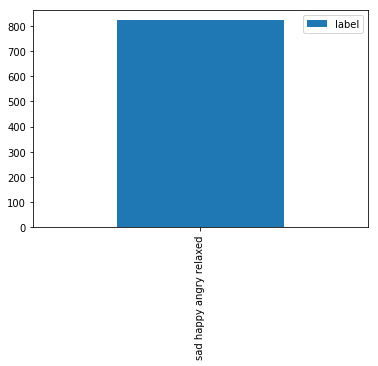

In [45]:
label = [label for label in labels]
count_label = np.array([labels[label] for label in labels])
df = pd.DataFrame({'label':count_label}, index=label)
ax = df.plot.bar(stacked=True)

# Cardinality and Diversity Dataset

In [46]:
df_data

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed
0,User1,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,Terasakan bagai mekar terbit asmara\nmerangkai...,None,HAPPY,None,None
1,User1,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,Sama seiring waktu\nLangkah ku menjadi kaku\nT...,SAD,None,None,None
2,User1,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,Satukan suara kita untuk bhumi arema\nTeriakan...,None,HAPPY,None,None
3,User1,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,Tiang masih berdiri\nBendera makin tinggi\nBer...,None,None,None,RELAXED
4,User1,Harvey Malaihollo and Elfa Secioria,Isyarat Semesta,https://lirik.kapanlagi.com/artis/harvey-malai...,full_lirik/Harvey Malaihollo and Elfa Secioria...,Isyarat Semesta.txt,Tengah malam tiba\nku masih terjaga\nku duduk ...,SAD,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
818,User4,Bobby Sandhora Muchsin,Hujan Lagi,https://lirik.kapanlagi.com/artis/bobby-sandho...,full_lirik/Bobby Sandhora Muchsin/Hujan Lagi.txt,Hujan Lagi.txt,Hujan lagi.. hujan lagi hujan lagi\nTurun airn...,SAD,None,None,None
819,User4,Casbie,Menjaga Dan Mencintaimu,https://lirik.kapanlagi.com/artis/casbie/menja...,full_lirik/Casbie/Menjaga Dan Mencintaimu.txt,Menjaga Dan Mencintaimu.txt,Ku telah lama mencintai dirimu\nDan semua rasa...,None,HAPPY,None,RELAXED
820,User4,7 Kurcaci,Lelah,https://lirik.kapanlagi.com/artis/7-kurcaci/le...,full_lirik/7 Kurcaci/Lelah.txt,Lelah.txt,"Lelah, cepatnya kau menyerah\nBenci, satu yang...",None,None,ANGRY,None
821,User4,7th Sky,Hanya Untuk Cinta,https://lirik.kapanlagi.com/artis/7th-sky/hany...,full_lirik/7th Sky/Hanya Untuk Cinta.txt,Hanya Untuk Cinta.txt,Bila segalanya telah terucapkan\nAkan ku satuk...,None,HAPPY,None,RELAXED


In [47]:
diversity = diversity_score(data)
print("Diversity : ", diversity)
cardinality = cardinality_score(data)
print("Cardinality : ", cardinality)

Diversity :  0.5
Cardinality :  1.0874848116646416


In [48]:


def count_exist_label(data):
    moods = ['sad', 'happy', 'angry', 'relaxed']
    count = 0
    for mood in moods:
        if data[mood] != None:
            count+=1
    return count


def count_terfilter(datas):
    total_data_filter= 0
    total_multilabel= 0
    titles_filter = []
    for data in datas:
        title = data['title']
        if title not in titles_filter:
            titles_filter.append(title)
    df_non_overlap = pd.DataFrame(datas)
    for title in titles_filter:
        total_data_filter +=1
        data_song = df_non_overlap[df_non_overlap['title']==title]
        for index, row in data_song.iterrows():
            counting = count_exist_label(row)
            if counting > 1:
                total_multilabel+=1
                break

    print("Total data filter ", total_data_filter)
    print("Total multilabel ", total_multilabel)
    print("Persentase : ", total_multilabel/total_data_filter)

DATASET_FILENAME = 'data/non_overlap_2same_kel1.json'
data_non_overlap_kel1 = load_dataset(DATASET_FILENAME)
count_terfilter(data_non_overlap_kel1)
DATASET_FILENAME = 'data/non_overlap_2same_kel2.json'
data_non_overlap_kel2 = load_dataset(DATASET_FILENAME)
count_terfilter(data_non_overlap_kel2)

Total data filter  154
Total multilabel  119
Persentase :  0.7727272727272727
Total data filter  97
Total multilabel  80
Persentase :  0.8247422680412371


In [49]:
df_data['sad'] = [1 if mood == 'SAD' else 0 for mood in df_data['sad']]
df_data['happy'] = [1 if mood == 'HAPPY' else 0 for mood in df_data['happy']]
df_data['angry'] = [1 if mood == 'ANGRY' else 0 for mood in df_data['angry']]
df_data['relaxed'] = [1 if mood == 'RELAXED' else 0 for mood in df_data['relaxed']]

df_data['lirik'] = df_data['lirik'].str.lower()
df_data['NUMBER_OF_WORDS'] = df_data['lirik'].apply(numberOfWords)
df_data['NUMBER_OF_UNIQUE_WORDS'] = df_data['lirik'].apply(numberOfUniqueWords)
df_data['NUMBER_OF_REPEATED_WORDS'] = df_data['lirik'].apply(numberRepeatedWords)
df_data['NUMBER_OF_LINE'] = df_data['lirik'].apply(numberOfLine)
df_data['NUMBER_OF_UNIQUE_SENTENCES'] = df_data['lirik'].apply(numberOfUniqueSentances)
df_data['NUMBER_OF_REPEATED_SENTENCES'] = df_data['lirik'].apply(numberRepeatedSentances)
df_data['IS_SARCASM'] = df_data['lirik'].apply(isSarcasm)
df_data['IS_SARCASM_WITH_SONG'] = df_data['lirik'].apply(isSarcasmWithSong)
df_data['SARKASME'] = [get_sarcasm(title) for title in df_data['title']]

df_data.head()

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed,NUMBER_OF_WORDS,NUMBER_OF_UNIQUE_WORDS,NUMBER_OF_REPEATED_WORDS,NUMBER_OF_LINE,NUMBER_OF_UNIQUE_SENTENCES,NUMBER_OF_REPEATED_SENTENCES,IS_SARCASM,IS_SARCASM_WITH_SONG,SARKASME
0,User1,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,terasakan bagai mekar terbit asmara\nmerangkai...,0,1,0,0,66,63,3,18,18,0,0,0,0
1,User1,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,sama seiring waktu\nlangkah ku menjadi kaku\nt...,1,0,0,0,29,21,8,14,9,5,0,0,0
2,User1,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,satukan suara kita untuk bhumi arema\nteriakan...,0,1,0,0,84,46,27,40,20,14,0,0,0
3,User1,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,tiang masih berdiri\nbendera makin tinggi\nber...,0,0,0,1,176,99,22,72,48,8,0,0,1
4,User1,Harvey Malaihollo and Elfa Secioria,Isyarat Semesta,https://lirik.kapanlagi.com/artis/harvey-malai...,full_lirik/Harvey Malaihollo and Elfa Secioria...,Isyarat Semesta.txt,tengah malam tiba\nku masih terjaga\nku duduk ...,1,0,0,0,62,53,7,24,23,1,0,0,0


In [50]:
df_data[df_data['IS_SARCASM']==0]

,username,musisi,title,link,path,filename,lirik,sad,happy,angry,relaxed,NUMBER_OF_WORDS,NUMBER_OF_UNIQUE_WORDS,NUMBER_OF_REPEATED_WORDS,NUMBER_OF_LINE,NUMBER_OF_UNIQUE_SENTENCES,NUMBER_OF_REPEATED_SENTENCES,IS_SARCASM,IS_SARCASM_WITH_SONG,SARKASME
0,User1,Dhenok Wahyudi,Asmaraku Asmaramu (duet with Indra Tjahja),https://lirik.kapanlagi.com/artis/dhenok-wahyu...,full_lirik/Dhenok Wahyudi/Asmaraku Asmaramu (d...,Asmaraku Asmaramu (duet with Indra Tjahja).txt,terasakan bagai mekar terbit asmara\nmerangkai...,0,1,0,0,66,63,3,18,18,0,0,0,0
1,User1,Inov,Tanpamu (feat. Kezia),https://lirik.kapanlagi.com/artis/inov/tanpamu...,full_lirik/Inov/Tanpamu (feat. Kezia).txt,Tanpamu (feat. Kezia).txt,sama seiring waktu\nlangkah ku menjadi kaku\nt...,1,0,0,0,29,21,8,14,9,5,0,0,0
2,User1,d'Kross,Satu Jiwa,https://lirik.kapanlagi.com/artis/dkross/satu-...,full_lirik/d'Kross/Satu Jiwa.txt,Satu Jiwa.txt,satukan suara kita untuk bhumi arema\nteriakan...,0,1,0,0,84,46,27,40,20,14,0,0,0
3,User1,.Feast,Kami Belum Tentu,https://lirik.kapanlagi.com/artis/ana-fitria/p...,full_lirik/Ana Fitria/Payung Batu.txt,Payung Batu.txt,tiang masih berdiri\nbendera makin tinggi\nber...,0,0,0,1,176,99,22,72,48,8,0,0,1
4,User1,Harvey Malaihollo and Elfa Secioria,Isyarat Semesta,https://lirik.kapanlagi.com/artis/harvey-malai...,full_lirik/Harvey Malaihollo and Elfa Secioria...,Isyarat Semesta.txt,tengah malam tiba\nku masih terjaga\nku duduk ...,1,0,0,0,62,53,7,24,23,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,User4,Bobby Sandhora Muchsin,Hujan Lagi,https://lirik.kapanlagi.com/artis/bobby-sandho...,full_lirik/Bobby Sandhora Muchsin/Hujan Lagi.txt,Hujan Lagi.txt,hujan lagi.. hujan lagi hujan lagi\nturun airn...,1,0,0,0,87,40,11,26,20,2,0,0,0
819,User4,Casbie,Menjaga Dan Mencintaimu,https://lirik.kapanlagi.com/artis/casbie/menja...,full_lirik/Casbie/Menjaga Dan Mencintaimu.txt,Menjaga Dan Mencintaimu.txt,ku telah lama mencintai dirimu\ndan semua rasa...,0,1,0,1,74,39,21,12,9,3,0,0,0
820,User4,7 Kurcaci,Lelah,https://lirik.kapanlagi.com/artis/7-kurcaci/le...,full_lirik/7 Kurcaci/Lelah.txt,Lelah.txt,"lelah, cepatnya kau menyerah\nbenci, satu yang...",0,0,1,0,238,148,45,49,45,4,0,0,0
821,User4,7th Sky,Hanya Untuk Cinta,https://lirik.kapanlagi.com/artis/7th-sky/hany...,full_lirik/7th Sky/Hanya Untuk Cinta.txt,Hanya Untuk Cinta.txt,bila segalanya telah terucapkan\nakan ku satuk...,0,1,0,1,52,39,9,21,18,2,0,0,0


In [51]:
lyric = df_data['lirik'][0]
lyric

"terasakan bagai mekar terbit asmara\nmerangkai cita harap pujiku memanja\nufuk surya seakan membias salam\nlewat sang alam, bak dilukiskan kalam\nterayun langkahku mengiring ayun langkahmu\nsenada searah melambung tinggi impian\nkilau emas jangankan kami kan hirau\njangankan silau pun terpukau\nreff.\ndadadadada......\nterhampar mekar mawar kugapai kau menjuntai\nmengoyak nestapa kukini t'lah terbuai\nsemaraknya hati tak usai beranjak\npun tak ku campak cerahkan nampak kelak\nasmaraku asmaramu membara sempurna\nmanjanya tawa melukis manisnya warna\nbahagiaku bahagiamu telah menjelma\ndunia bak milik berdua\n"

# Debug Word

In [52]:
word  = numberOfWords(lyric)
word

66

In [53]:
uniqueWord  = numberOfUniqueWords(lyric)
uniqueWord

63

In [54]:
repeatWord = numberRepeatedSentances(lyric)
repeatWord

0

In [55]:
repeatWords = getRepeatedWords(lyric)
repeatWords

{'mekar': 2, 'bak': 2, 'tak': 2}

In [56]:
tokenisasi_word(lyric)

['terasakan',
 'bagai',
 'mekar',
 'terbit',
 'asmaramerangkai',
 'cita',
 'harap',
 'pujiku',
 'memanjaufuk',
 'surya',
 'seakan',
 'membias',
 'salamlewat',
 'sang',
 'alam',
 'bak',
 'dilukiskan',
 'kalamterayun',
 'langkahku',
 'mengiring',
 'ayun',
 'langkahmusenada',
 'searah',
 'melambung',
 'tinggi',
 'impiankilau',
 'emas',
 'jangankan',
 'kami',
 'kan',
 'hiraujangankan',
 'silau',
 'pun',
 'terpukaureffdadadadadaterhampar',
 'mekar',
 'mawar',
 'kugapai',
 'kau',
 'menjuntaimengoyak',
 'nestapa',
 'kukini',
 'tlah',
 'terbuaisemaraknya',
 'hati',
 'tak',
 'usai',
 'beranjakpun',
 'tak',
 'ku',
 'campak',
 'cerahkan',
 'nampak',
 'kelakasmaraku',
 'asmaramu',
 'membara',
 'sempurnamanjanya',
 'tawa',
 'melukis',
 'manisnya',
 'warnabahagiaku',
 'bahagiamu',
 'telah',
 'menjelmadunia',
 'bak',
 'milik',
 'berdua']

# Debug Sentences

In [57]:
line  = numberOfLine(lyric)
line

18

In [58]:
unique  = numberOfUniqueSentances(lyric)
unique

18

In [59]:
repeat = numberRepeatedSentances(lyric)
repeat

0

In [60]:
repeatSentences = getRepeatedSentances(lyric)
repeatSentences

{}

In [61]:
tokenisasi_sentence(lyric)

['terasakan bagai mekar terbit asmara',
 'merangkai cita harap pujiku memanja',
 'ufuk surya seakan membias salam',
 'lewat sang alam, bak dilukiskan kalam',
 'terayun langkahku mengiring ayun langkahmu',
 'senada searah melambung tinggi impian',
 'kilau emas jangankan kami kan hirau',
 'jangankan silau pun terpukau',
 'reff.',
 'dadadadada......',
 'terhampar mekar mawar kugapai kau menjuntai',
 "mengoyak nestapa kukini t'lah terbuai",
 'semaraknya hati tak usai beranjak',
 'pun tak ku campak cerahkan nampak kelak',
 'asmaraku asmaramu membara sempurna',
 'manjanya tawa melukis manisnya warna',
 'bahagiaku bahagiamu telah menjelma',
 'dunia bak milik berdua']

In [62]:
print("Baris : ", df_data.shape[0])
print("Kolom : ", df_data.shape[1])
data_train, data_validation = split_dataset(df_data, 0.9)
print("Train : ", len(data_train), "Validation : ",len(data_validation))
df_data_train = pd.DataFrame(data_train)
df_data_validation = pd.DataFrame(data_validation)

Baris :  823
Kolom :  20
Train :  748 Validation :  75


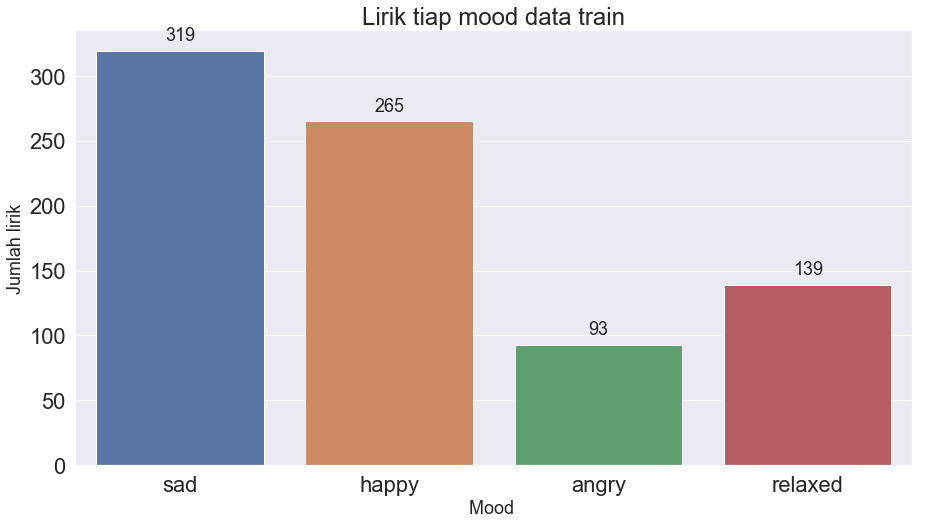

In [63]:
moods = list(['sad', 'happy', 'angry', 'relaxed'])
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(moods, df_data_train.iloc[:,7:11].sum().values)
plt.title("Lirik tiap mood data train", fontsize=24)
plt.ylabel('Jumlah lirik', fontsize=18)
plt.xlabel('Mood ', fontsize=18)
rects = ax.patches
labels = df_data_train.iloc[:,7:11].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

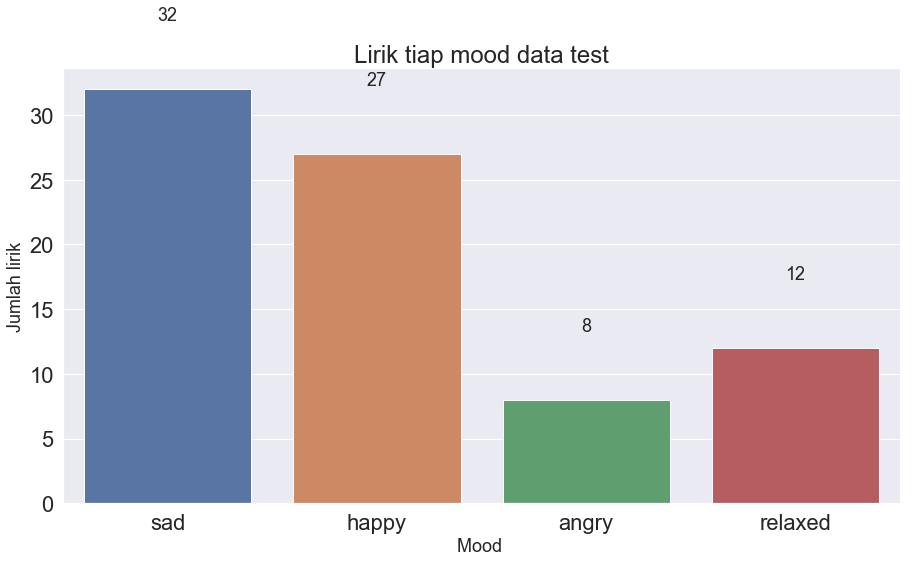

In [64]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(moods, df_data_validation.iloc[:,7:11].sum().values)
plt.title("Lirik tiap mood data test", fontsize=24)
plt.ylabel('Jumlah lirik', fontsize=18)
plt.xlabel('Mood ', fontsize=18)
#adding the text labels
rects = ax.patches
labels = df_data_validation.iloc[:,7:11].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()

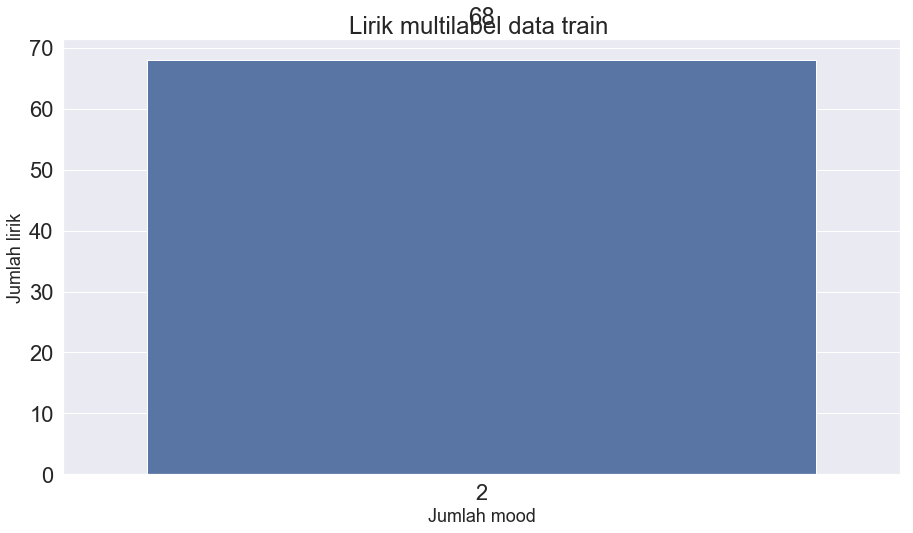

In [65]:
rowSums = df_data_train.iloc[:,7:11].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Lirik multilabel data train ")
plt.ylabel('Jumlah lirik', fontsize=18)
plt.xlabel('Jumlah mood', fontsize=18)
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [66]:
# rowSums = df_data_validation.iloc[:,7:11].sum(axis=1)
# multiLabel_counts = rowSums.value_counts()
# multiLabel_counts = multiLabel_counts.iloc[1:]
# sns.set(font_scale = 2)
# plt.figure(figsize=(15,8))
# ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
# plt.title("Lirik multilabel data test ")
# plt.ylabel('Jumlah lirik', fontsize=18)
# plt.xlabel('Jumlah mood', fontsize=18)
# rects = ax.patches
# labels = multiLabel_counts.values
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
# plt.show()

In [67]:
#Analisis Sarkasme
total_sarcasm_train = df_data_train[df_data_train['SARKASME']==1]['SARKASME'].count()
total_data_train = df_data_train['title'].count()
print('Dari data training Terdeteksi '+str(total_sarcasm_train)+' dari '+str(total_data_train)+'(%.2f' % ((total_sarcasm_train/total_data_train)*100) +'%)')


total_sarcasm_test = df_data_validation[df_data_validation['SARKASME']==1]['SARKASME'].count()
total_data_test = df_data_validation['title'].count()
print('Dari data validation Terdeteksi '+str(total_sarcasm_test)+' dari '+str(total_data_test)+'(%.2f' % ((total_sarcasm_test/total_data_test)*100) +'%)')

Dari data training Terdeteksi 47 dari 748(6.28%)
Dari data validation Terdeteksi 4 dari 75(5.33%)


In [68]:
classifiers = {}
BRGausian = BinaryRelevance(GaussianNB())
BRLogisticRegression = BinaryRelevance(LogisticRegression())
BRSVC = BinaryRelevance(make_pipeline(StandardScaler(), SVC(gamma='auto')))
LPGausian = LabelPowerset(GaussianNB())
LPLogisticRegression = LabelPowerset(LogisticRegression())
LPSVC = LabelPowerset(make_pipeline(StandardScaler(), SVC(gamma='auto')))

classifiers['BR Gausian'] = BRGausian
classifiers['BR LogisticRegression'] = BRLogisticRegression
classifiers['BR SVC'] = BRSVC
classifiers['LP Gausian'] = LPGausian
classifiers['LP LogisticRegression'] = LPLogisticRegression
classifiers['LP SVC'] = LPSVC
list_label = ['sad', 'happy', 'angry', 'relaxed']

In [69]:
def process_classifier(x_train, y_train, x_test, y_test):
    stats = {}
    for classifier in classifiers:
        clf = classifiers[classifier]
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        acc = example_based_acc(y_test,predictions)
        stats[classifier] = acc
    return stats

# KFOLD

In [70]:
print(len(data_train), len(data_validation))
data_label = split_dataset_cross(data_train)
data_cross_ready = split_cross_val(data_label,data, cv=5)

748 75
0 1 0 0 242 242
1 0 0 0 272 514
0 0 0 1 108 622
0 0 1 0 58 680
1 0 1 0 35 715
0 1 0 1 21 736
1 0 0 1 10 746
1 1 0 0 2 748


In [71]:
data_validation

[{'username': 'User4',
  'musisi': 'Aas Ariska',
  'title': 'Tanda Tanda Cinta',
  'link': 'https://lirik.kapanlagi.com/artis/aas-ariska/tanda-tanda-cinta/',
  'path': 'full_lirik/Aas Ariska/Tanda Tanda Cinta.txt',
  'filename': 'Tanda Tanda Cinta.txt',
  'lirik': 'tanda-tanda adanya cinta\ndiam-diam namun terasa\nada getar didada, ada rasa dimata\nkala bertemu pandang\ntanda-tanda adanya cinta\ntak terlihat namun terasa\nterasa dalam hati, terasa dalam khayal\nmelamun merindukan\ntanda-tanda rasa cinta\nanehnya rasa cinta\nunak aniknya cinta\nrupanya cinta memang tak nyata\ntapi ada tanda-tandanya\ncuma hati yang merasa\ntanda-tanda adanya cinta\ntak terlihat namun terasa\nterasa dalam hati, terasa dalam khayal\nmelamun merindukan\ntanda-tanda rasa cinta\nanehnya rasa cinta\nunak aniknya cinta\nrupanya cinta memang tak nyata\ntapi ada tanda-tandanya\ncuma hati yang merasa\ntanda-tanda adanya cinta\ntak terlihat namun terasa\nterasa dalam hati, terasa dalam khayal\nmelamun merindukan\n

In [72]:
for index in data_cross_ready:
    df_train = pd.DataFrame(data_cross_ready[index]['train'])
    df_test = pd.DataFrame(data_cross_ready[index]['test'])
    print('TRAIN :', df_train.shape[0])
    print('TEST : ', df_test.shape[0])

TRAIN : 600
TEST :  148
TRAIN : 600
TEST :  148
TRAIN : 601
TEST :  147
TRAIN : 601
TEST :  147
TRAIN : 601
TEST :  147


In [73]:
def process_kfold(list_feature):
    stats_kfold = {}
    stdev_kfold = {}
    for classifier in classifiers:
        stats_kfold[classifier] = []

    for index in data_cross_ready:
        df_train = pd.DataFrame(data_cross_ready[index]['train'])
        df_test = pd.DataFrame(data_cross_ready[index]['test'])


        base_x_train = df_train[list_feature]
        base_y_train = df_train[list_label]
        base_x_test = df_test[list_feature]
        base_y_test = df_test[list_label]

        stats = process_classifier(base_x_train, base_y_train, base_x_test, base_y_test)
        for stat in stats:
            stats_kfold[stat].append(stats[stat])

    for acc in stats_kfold:
        stdev_kfold[acc] = np.std(stats_kfold[acc])
        stats_kfold[acc] = np.mean(stats_kfold[acc])  
    return stats_kfold, stdev_kfold


## Prepare Fitur Baseline Tanpa Sarkasme

In [74]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES']
stats_kfold_base_without_sarcasm, stdev_kfold_base_without_sarcasm = process_kfold(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


## Prepare Fitur Baseline Dengan Model Sarkasme

In [75]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'IS_SARCASM']
stats_kfold_base_with_model_sarcasm, stdev_kfold_base_with_model_sarcasm = process_kfold(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/

In [76]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'IS_SARCASM_WITH_SONG']
stats_kfold_base_with_model_sarcasm_with_song, stdev_kfold_base_with_model_sarcasm_with_song = process_kfold(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/

## Prepare Fitur Baseline Dengan Label Sarkasme

In [77]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'SARKASME']
stats_kfold_base_with_label_sarcasm, stdev_kfold_base_with_label_sarcasm = process_kfold(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versi

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/

In [78]:
stats_kfold_base_without_sarcasm


{'BR Gausian': 0.6892581356867071,
 'BR LogisticRegression': 0.7218468468468469,
 'BR SVC': 0.7242209045780474,
 'LP Gausian': 0.6790839308696452,
 'LP LogisticRegression': 0.6923469387755102,
 'LP SVC': 0.6964055892627321}

In [79]:
stats_kfold_base_with_model_sarcasm


{'BR Gausian': 0.6329012686155544,
 'BR LogisticRegression': 0.721509009009009,
 'BR SVC': 0.7238853649567936,
 'LP Gausian': 0.5531692406692407,
 'LP LogisticRegression': 0.6940338297481154,
 'LP SVC': 0.7035415517558375}

In [80]:
stats_kfold_base_with_label_sarcasm

{'BR Gausian': 0.6403819635962493,
 'BR LogisticRegression': 0.7231683213826072,
 'BR SVC': 0.7296332046332046,
 'LP Gausian': 0.6675422871851444,
 'LP LogisticRegression': 0.6855166390880677,
 'LP SVC': 0.6957299135870565}

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

def preprocessing(lyric):
    tokens = []
    sentences = tokenisasi_sentence(lyric)
    for sentence in sentences:
        tokens += tokenisasi_word(sentence)

    word_tokens_no_stopwords = [w for w in tokens if not w in stop_words]
    return " ".join(tokens)

    
vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
                         tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)

# Kfold

In [82]:
def process_kfold_tfidf(list_feature):
    vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
                         tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)
    stats_kfold = {}
    stdev_kfold = {}
    for classifier in classifiers:
        stats_kfold[classifier] = []

    for index in data_cross_ready:
        vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
                         tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)

        df_train = pd.DataFrame(data_cross_ready[index]['train'])
        df_test = pd.DataFrame(data_cross_ready[index]['test'])

        #         train = pd.DataFrame(data_train)
        #         test = pd.DataFrame(data_validation)

        df_train['lirik'] = df_train['lirik'].apply(preprocessing)
        df_test['lirik'] = df_test['lirik'].apply(preprocessing)

        tfidf_x_train = vector.fit_transform(df_train['lirik'])
        tfidf_y_train = df_train[list_label]
        tfidf_x_test = vector.transform(df_test['lirik'])
        tfidf_y_test = df_test[list_label]

        
        tfidf_tokens = vector.get_feature_names()
        X_train_df_tfidfvect = pd.DataFrame(data = tfidf_x_train.toarray(),columns = tfidf_tokens)
        X_train_filter = X_train_df_tfidfvect
        new_X_train = pd.concat((X_train_filter, df_train[list_feature]), axis=1)
        new_X_train = new_X_train.fillna(0)
        # 
        X_test_df_tfidfvect = pd.DataFrame(data = tfidf_x_test.toarray(),columns = tfidf_tokens)
        X_test_filter = X_test_df_tfidfvect
        new_X_test = pd.concat((X_test_filter, df_test[list_feature]), axis=1)
        new_X_test = new_X_test.fillna(0)

        #         base_x_train = df_train[list_feature]
        #         base_y_train = df_train[list_label]
        #         base_x_test = df_test[list_feature]
        #         base_y_test = df_test[list_label]

        stats = process_classifier(new_X_train, tfidf_y_train, new_X_test, tfidf_y_test)
        for stat in stats:
            stats_kfold[stat].append(stats[stat])
    
    for acc in stats_kfold:
        stdev_kfold[acc] = np.std(stats_kfold[acc])
        stats_kfold[acc] = np.mean(stats_kfold[acc])  
    return stats_kfold, stdev_kfold


# Prepare fitur TDIDF tanpa sarkasme

In [83]:
list_feature = []
stats_kfold_tfidf_without_sarcasm, stdev_kfold_tfidf_without_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

In [84]:
stdev_kfold_tfidf_without_sarcasm

{'BR Gausian': 0.011133246211553507,
 'BR LogisticRegression': 0.007316142110174103,
 'BR SVC': 0.011358777310012063,
 'LP Gausian': 0.012621379891608326,
 'LP LogisticRegression': 0.008940831701535359,
 'LP SVC': 0.010040503994493622}

# Prepare fitur TDIDF dengan model sarkasme

In [85]:
list_feature = ['IS_SARCASM']
stats_kfold_tfidf_with_model_sarcasm, stdev_kfold_tfidf_with_model_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Prepare fitur TDIDF dengan model sarkasme with song

In [86]:
list_feature = ['IS_SARCASM_WITH_SONG']
stats_kfold_tfidf_with_model_sarcasm_with_song, stdev_kfold_tfidf_with_model_sarcasm_with_song = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Prepare fitur TDIDF dengan label sarkasme

In [87]:
list_feature = ['SARKASME']
stats_kfold_tfidf_with_label_sarcasm, stdev_kfold_tfidf_with_label_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Prepare fitur TDIDF + base tanpa sarkasme

In [88]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES']
stats_kfold_tfidf_base_without_sarcasm, stdev_kfold_tfidf_base_without_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Prepare fitur TDIDF + base dengan model sarkasme

In [89]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'IS_SARCASM']
stats_kfold_tfidf_base_with_model_sarcasm, stdev_kfold_tfidf_base_with_model_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Prepare fitur TDIDF + base dengan label sarkasme

In [90]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'SARKASME']
stats_kfold_tfidf_base_with_label_sarcasm, stdev_kfold_tfidf_base_with_label_sarcasm = process_kfold_tfidf(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

# Fasttext

In [91]:
def get_embedding(word):
    try:
        embedding=ft[word]
    except:
        embedding=np.zeros((300,))
    return embedding


In [92]:
import fasttext
import fasttext.util
loc="cc.id.300.bin"
loc="fasttext.4B.id.300.epoch5.uncased.bin"
ft = fasttext.load_model(loc) 

In [93]:
# oov = []
# for words in X:
#     for word in words:
#         try:
#             embedding=ft[word]
#         except:
#             oov.append(word)


In [94]:
# print(len(oov))

In [95]:
# frames = [X_train, y_train]
# result = pd.concat(frames, axis=1, join="inner")
# result.corr()[result.corr()['sad']>0.2]

## KFOLD


In [96]:
def process_kfold_fasttext(list_feature):
#     vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
#                          tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)
    stats_kfold = {}
    stdev_kfold = {}
    for classifier in classifiers:
        stats_kfold[classifier] = []

    for index in data_cross_ready:
#         vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
#                          tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)

        df_train = pd.DataFrame(data_cross_ready[index]['train'])
        df_test = pd.DataFrame(data_cross_ready[index]['test'])

        df_train['lirik'] = df_train['lirik'].apply(preprocessing)
        df_test['lirik'] = df_test['lirik'].apply(preprocessing)

        X=[tokenisasi_word(sent) for sent in df_train['lirik']] 
        fasttext_x_train = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
        fasttext_y_train = df_train[list_label]
        Y=[tokenisasi_word(sent) for sent in df_test['lirik']] 
        fasttext_x_test = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in Y])
        fasttext_y_test = df_test[list_label]

        
        new_X_train = pd.concat((fasttext_x_train, df_train[list_feature]), axis=1)
        new_X_train = new_X_train.fillna(0)

        new_X_test = pd.concat((fasttext_x_test, df_test[list_feature]), axis=1)
        new_X_test = new_X_test.fillna(0)


        stats = process_classifier(new_X_train, fasttext_y_train, new_X_test, fasttext_y_test)
        for stat in stats:
            stats_kfold[stat].append(stats[stat])
    
    for acc in stats_kfold:
        stdev_kfold[acc] = np.std(stats_kfold[acc])
        stats_kfold[acc] = np.mean(stats_kfold[acc]) 
    return stats_kfold, stdev_kfold


## Prepare feature Fasttext tanpa sarkasme

In [97]:
list_feature = []
stats_kfold_fasttext_without_sarcasm, stdev_kfold_fasttext_without_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

## Prepare feature Fasttext dengan model sarkasme

In [98]:
list_feature = ['IS_SARCASM']
stats_kfold_fasttext_with_model_sarcasm, stdev_kfold_fasttext_with_model_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

## Prepare feature Fasttext dengan label sarkasme

In [99]:
list_feature = ['SARKASME']
stats_kfold_fasttext_with_label_sarcasm, stdev_kfold_fasttext_with_label_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

## Prepare feature Fasttext + Base tanpa sarkasme

In [100]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES']
stats_kfold_fasttext_base_without_sarcasm, stdev_kfold_fasttext_base_without_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

## Prepare feature Fasttext + Base dengan model sarkasme

In [101]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'IS_SARCASM']
stats_kfold_fasttext_base_with_model_sarcasm, stdev_kfold_fasttext_base_with_model_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

## Prepare feature Fasttext + Base dengan label sarkasme

In [102]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'SARKASME']
stats_kfold_fasttext_base_with_label_sarcasm, stdev_kfold_fasttext_base_with_label_sarcasm = process_kfold_fasttext(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

In [103]:
data_all_train = data_cross_ready[0]['train']+data_cross_ready[1]['train']+data_cross_ready[2]['train']+data_cross_ready[3]['train']+data_cross_ready[4]['train']
data_all_test = data_cross_ready[0]['test']+data_cross_ready[1]['test']+data_cross_ready[2]['test']+data_cross_ready[3]['test']+data_cross_ready[4]['test']

data_all = data_all_train + data_all_test
df_data_all=pd.DataFrame(data_all)
df_data_all['lirik'] = df_data_all['lirik'].apply(preprocessing)
lirik_all = [lirik for lirik in df_data_all['lirik']]
join_lirik_all = " ".join(lirik_all)

f = open("lirik_all.txt", "a")
f.write(join_lirik_all)
f.close()

from pprint import pprint as print
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath

# Set file names for train and test data
corpus_file = "lirik_all.txt"

model = FastText(vector_size=300)

# build the vocabulary
model.build_vocab(corpus_file=corpus_file)

# train the model
model.train(
    corpus_file=corpus_file, epochs=model.epochs,
    total_examples=model.corpus_count, total_words=model.corpus_total_words,
)
import tempfile
import os
with tempfile.NamedTemporaryFile(prefix='saved_model_gensim-', delete=False) as tmp:
    model.save(tmp.name, separately=[])

loaded_model = FastText.load(tmp.name)
print(loaded_model)
wv = loaded_model.wv



In [104]:
def get_embedding_own(word):
    try:
        embedding=wv[word]
    except:
        embedding=np.zeros((300,))
    return embedding
def process_kfold_fasttext_own(list_feature):
#     vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
#                          tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)
    stats_kfold = {}
    stdev_kfold = {}
    for classifier in classifiers:
        stats_kfold[classifier] = []

    for index in data_cross_ready:
#         vector = TfidfVectorizer(ngram_range=(1, 2), analyzer='word',
#                          tokenizer=tokenize, strip_accents='unicode', use_idf=1, min_df=10)

        df_train = pd.DataFrame(data_cross_ready[index]['train'])
        df_test = pd.DataFrame(data_cross_ready[index]['test'])

        df_train['lirik'] = df_train['lirik'].apply(preprocessing)
        df_test['lirik'] = df_test['lirik'].apply(preprocessing)

        X=[tokenisasi_word(sent) for sent in df_train['lirik']] 
        fasttext_x_train = pd.DataFrame([np.mean(np.array(list(map(get_embedding_own,tok_sent))),axis=0) for tok_sent in X])
        fasttext_y_train = df_train[list_label]
        Y=[tokenisasi_word(sent) for sent in df_test['lirik']] 
        fasttext_x_test = pd.DataFrame([np.mean(np.array(list(map(get_embedding_own,tok_sent))),axis=0) for tok_sent in Y])
        fasttext_y_test = df_test[list_label]

        
        new_X_train = pd.concat((fasttext_x_train, df_train[list_feature]), axis=1)
        new_X_train = new_X_train.fillna(0)

        new_X_test = pd.concat((fasttext_x_test, df_test[list_feature]), axis=1)
        new_X_test = new_X_test.fillna(0)


        stats = process_classifier(new_X_train, fasttext_y_train, new_X_test, fasttext_y_test)
        for stat in stats:
            stats_kfold[stat].append(stats[stat])
    
    for acc in stats_kfold:
        stdev_kfold[acc] = np.std(stats_kfold[acc])
        stats_kfold[acc] = np.mean(stats_kfold[acc]) 
    return stats_kfold, stdev_kfold





In [105]:
list_feature = []
stats_kfold_fasttext_own_without_sarcasm, stdev_kfold_fasttext_own_without_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

In [106]:
list_feature = ['IS_SARCASM']
stats_kfold_fasttext_own_with_model_sarcasm, stdev_kfold_fasttext_own_with_model_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

In [107]:
list_feature = ['SARKASME']
stats_kfold_fasttext_own_with_label_sarcasm, stdev_kfold_fasttext_own_with_label_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writa

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

In [108]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES']
stats_kfold_fasttext_own_base_without_sarcasm, stdev_kfold_fasttext_own_base_without_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chan

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

In [109]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'IS_SARCASM']
stats_kfold_fasttext_own_base_with_model_sarcasm, stdev_kfold_fasttext_own_base_with_model_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broa

In [110]:
list_feature = ['NUMBER_OF_WORDS', 'NUMBER_OF_UNIQUE_WORDS', 'NUMBER_OF_REPEATED_WORDS' , 'NUMBER_OF_LINE', 'NUMBER_OF_UNIQUE_SENTENCES',
              'NUMBER_OF_REPEATED_SENTENCES', 'SARKASME']
stats_kfold_fasttext_own_base_with_label_sarcasm, stdev_kfold_fasttext_own_base_with_label_sarcasm = process_kfold_fasttext_own(list_feature)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself.

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will

/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be chan

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(job

In [111]:


print("\n Kfold BASE Tanpa Sarcasm")
print(pd.Series(stats_kfold_base_without_sarcasm))
print("\n Kfold BASE Model Sarcasm")
print(pd.Series(stats_kfold_base_with_model_sarcasm))
print("\n Kfold BASE Label Sarcasm")
print(pd.Series(stats_kfold_base_with_label_sarcasm))


print("\n Kfold TFIDF Tanpa Sarcasm")
print(pd.Series(stats_kfold_tfidf_without_sarcasm))
print("\n Kfold TFIDF Model Sarcasm")
print(pd.Series(stats_kfold_tfidf_with_model_sarcasm))
print("\n Kfold TFIDF Label Sarcasm")
print(pd.Series(stats_kfold_tfidf_with_label_sarcasm))

print("\n Kfold TFIDF BASE Tanpa Sarcasm")
print(pd.Series(stats_kfold_tfidf_base_without_sarcasm))
print("\n Kfold TFIDF BASE Model Sarcasm")
print(pd.Series(stats_kfold_tfidf_base_with_model_sarcasm))
print("\n Kfold TFIDF BASE Label Sarcasm")
print(pd.Series(stats_kfold_tfidf_base_with_label_sarcasm))

print("\n Kfold FastText Tanpa Sarcasm")
print(pd.Series(stats_kfold_fasttext_without_sarcasm))
print("\n Kfold FastText Model Sarcasm")
print(pd.Series(stats_kfold_fasttext_with_model_sarcasm))
print("\n Kfold FastText Label Sarcasm")
print(pd.Series(stats_kfold_fasttext_with_label_sarcasm))

print("\n Kfold FastText BASE Tanpa Sarcasm")
print(pd.Series(stats_kfold_fasttext_base_without_sarcasm))
print("\n Kfold FastText BASE Model Sarcasm")
print(pd.Series(stats_kfold_fasttext_base_with_model_sarcasm))
print("\n Kfold FastText BASE Label Sarcasm")
print(pd.Series(stats_kfold_fasttext_base_with_label_sarcasm))

print("\n Kfold FastText Own Tanpa Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_without_sarcasm))
print("\n Kfold FastText Own Model Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_with_model_sarcasm))
print("\n Kfold FastText Own Label Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_with_label_sarcasm))

print("\n Kfold FastText Own BASE Tanpa Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_base_without_sarcasm))
print("\n Kfold FastText Own BASE Model Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_base_with_model_sarcasm))
print("\n Kfold FastText Own BASE Label Sarcasm")
print(pd.Series(stats_kfold_fasttext_own_base_with_label_sarcasm))

'\n Kfold BASE Tanpa Sarcasm'
BR Gausian               0.689258
BR LogisticRegression    0.721847
BR SVC                   0.724221
LP Gausian               0.679084
LP LogisticRegression    0.692347
LP SVC                   0.696406
dtype: float64
'\n Kfold BASE Model Sarcasm'
BR Gausian               0.632901
BR LogisticRegression    0.721509
BR SVC                   0.723885
LP Gausian               0.553169
LP LogisticRegression    0.694034
LP SVC                   0.703542
dtype: float64
'\n Kfold BASE Label Sarcasm'
BR Gausian               0.640382
BR LogisticRegression    0.723168
BR SVC                   0.729633
LP Gausian               0.667542
LP LogisticRegression    0.685517
LP SVC                   0.695730
dtype: float64
'\n Kfold TFIDF Tanpa Sarcasm'
BR Gausian               0.683147
BR LogisticRegression    0.775427
BR SVC                   0.762530
LP Gausian               0.720146
LP LogisticRegression    0.764235
LP SVC                   0.753365
dtype: float64
'\n

In [112]:
stats_all = [] 
titles = [
    "Kfold BASE Tanpa Sarcasm",
    "Kfold BASE Model Sarcasm",
    "Kfold BASE Label Sarcasm",
    "Kfold TFIDF Tanpa Sarcasm",
    "Kfold TFIDF Model Sarcasm",
    "Kfold TFIDF Label Sarcasm",
    "Kfold TFIDF BASE Tanpa Sarcasm",
    "Kfold TFIDF BASE Model Sarcasm",
    "Kfold TFIDF BASE Label Sarcasm",
    "Kfold FastText Tanpa Sarcasm",
    "Kfold FastText Model Sarcasm",
    "Kfold FastText Label Sarcasm",
    "Kfold FastText BASE Tanpa Sarcasm",
    "Kfold FastText BASE Model Sarcasm",
    "Kfold FastText BASE Label Sarcasm",
    "Kfold FastText Own Tanpa Sarcasm",
    "Kfold FastText Own Own Model Sarcasm",
    "Kfold FastText Own Label Sarcasm",
    "Kfold FastText Own BASE Tanpa Sarcasm",
    "Kfold FastText Own BASE Model Sarcasm",
    "Kfold FastText Own BASE Label Sarcasm"
    
]
stats_all.append(stats_kfold_base_without_sarcasm)
stats_all.append(stats_kfold_base_with_model_sarcasm)
stats_all.append(stats_kfold_base_with_label_sarcasm)
stats_all.append(stats_kfold_tfidf_without_sarcasm)
stats_all.append(stats_kfold_tfidf_with_model_sarcasm)
stats_all.append(stats_kfold_tfidf_with_label_sarcasm)
stats_all.append(stats_kfold_tfidf_base_without_sarcasm)
stats_all.append(stats_kfold_tfidf_base_with_model_sarcasm)
stats_all.append(stats_kfold_tfidf_base_with_label_sarcasm)
stats_all.append(stats_kfold_fasttext_without_sarcasm)
stats_all.append(stats_kfold_fasttext_with_model_sarcasm)
stats_all.append(stats_kfold_fasttext_with_label_sarcasm)
stats_all.append(stats_kfold_fasttext_base_without_sarcasm)
stats_all.append(stats_kfold_fasttext_base_with_model_sarcasm)
stats_all.append(stats_kfold_fasttext_base_with_label_sarcasm)
stats_all.append(stats_kfold_fasttext_own_without_sarcasm)
stats_all.append(stats_kfold_fasttext_own_with_model_sarcasm)
stats_all.append(stats_kfold_fasttext_own_with_label_sarcasm)
stats_all.append(stats_kfold_fasttext_own_base_without_sarcasm)
stats_all.append(stats_kfold_fasttext_own_base_with_model_sarcasm)
stats_all.append(stats_kfold_fasttext_own_base_with_label_sarcasm)
datas = []
for title, stats in zip(titles, stats_all):
    data = [title, stats['BR Gausian'], 
        stats['BR LogisticRegression'],stats['BR SVC'],
        stats['LP Gausian'],stats['LP LogisticRegression'],
        stats['LP SVC']]
    datas.append(data)

df_stats = pd.DataFrame(datas, columns=['Skenario', 'BR Gausian', 'BR LogisticRegression', 'BR SVC', 'LP Gausian', 'LP LogisticRegression', 'LP SVC'])
df_stats.to_csv('stats_2same.csv', float_format='%g') 


In [113]:
stdev_all = [] 
titles = [
    "Kfold BASE Tanpa Sarcasm",
    "Kfold BASE Model Sarcasm",
    "Kfold BASE Label Sarcasm",
    "Kfold TFIDF Tanpa Sarcasm",
    "Kfold TFIDF Model Sarcasm",
    "Kfold TFIDF Label Sarcasm",
    "Kfold TFIDF BASE Tanpa Sarcasm",
    "Kfold TFIDF BASE Model Sarcasm",
    "Kfold TFIDF BASE Label Sarcasm",
    "Kfold FastText Tanpa Sarcasm",
    "Kfold FastText Model Sarcasm",
    "Kfold FastText Label Sarcasm",
    "Kfold FastText BASE Tanpa Sarcasm",
    "Kfold FastText BASE Model Sarcasm",
    "Kfold FastText BASE Label Sarcasm",
    "Kfold FastText Own Tanpa Sarcasm",
    "Kfold FastText Own Model Sarcasm",
    "Kfold FastText Own Label Sarcasm",
    "Kfold FastText Own BASE Tanpa Sarcasm",
    "Kfold FastText Own BASE Model Sarcasm",
    "Kfold FastText Own BASE Label Sarcasm"
    
]
stdev_all.append(stdev_kfold_base_without_sarcasm)
stdev_all.append(stdev_kfold_base_with_model_sarcasm)
stdev_all.append(stdev_kfold_base_with_label_sarcasm)
stdev_all.append(stdev_kfold_tfidf_without_sarcasm)
stdev_all.append(stdev_kfold_tfidf_with_model_sarcasm)
stdev_all.append(stdev_kfold_tfidf_with_label_sarcasm)
stdev_all.append(stdev_kfold_tfidf_base_without_sarcasm)
stdev_all.append(stdev_kfold_tfidf_base_with_model_sarcasm)
stdev_all.append(stdev_kfold_tfidf_base_with_label_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_without_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_with_model_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_with_label_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_base_without_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_base_with_model_sarcasm)
stdev_all.append(stdev_kfold_fasttext_own_base_with_label_sarcasm)
datas = []
for title, stdev in zip(titles, stdev_all):
    data = [title, stdev['BR Gausian'], 
        stdev['BR LogisticRegression'],stdev['BR SVC'],
        stdev['LP Gausian'],stdev['LP LogisticRegression'],
        stdev['LP SVC']]
    datas.append(data)

df_stdev = pd.DataFrame(datas, columns=['Skenario', 'BR Gausian', 'BR LogisticRegression', 'BR SVC', 'LP Gausian', 'LP LogisticRegression', 'LP SVC'])
df_stdev.to_csv('stdev_2same.csv', float_format='%g') 



In [114]:

def get_model(n_inputs, n_outputs):
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def evaluate_model(X, y):
    results = list()
    n_inputs, n_outputs = X.shape[1], y.shape[1]
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=1)
    for train_ix, test_ix in cv.split(X):
        X_train, X_test = X[train_ix], X[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        model = get_model(n_inputs, n_outputs)
        model.fit(X_train, y_train, verbose=0, epochs=100)
        yhat = model.predict(X_test)
        yhat = yhat.round()
        acc = accuracy_score(y_test, yhat)
        print('>%.3f' % acc)
        results.append(acc)
    return results

In [115]:

# data_all_train = data_cross_ready[0]['train']+data_cross_ready[1]['train']+data_cross_ready[2]['train']+data_cross_ready[3]['train']+data_cross_ready[4]['train']
# data_all_test = data_cross_ready[0]['test']+data_cross_ready[1]['test']+data_cross_ready[2]['test']+data_cross_ready[3]['test']+data_cross_ready[4]['test']
# df_train = pd.DataFrame(data_all_train)
# df_test = pd.DataFrame(data_all_test)

# df_train['lirik'] = df_train['lirik'].apply(preprocessing)
# df_test['lirik'] = df_test['lirik'].apply(preprocessing)

# X=[tokenisasi_word(sent) for sent in df_train['lirik']] 
# fasttext_x_train = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
# fasttext_y_train = df_train[list_label]
# Y=[tokenisasi_word(sent) for sent in df_test['lirik']] 
# fasttext_x_test = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in Y])
# fasttext_y_test = df_test[list_label]


# new_X_train = pd.concat((fasttext_x_train, df_train[[]]), axis=1)
# new_X_train = new_X_train.fillna(0)

# new_X_test = pd.concat((fasttext_x_test, df_test[[]]), axis=1)
# new_X_test = new_X_test.fillna(0)
# new_X_train
# results = evaluate_model(np.array(new_X_train), np.array(fasttext_y_train))

In [116]:
# print('Accuracy: %.3f (%.3f)' % (mean(results), std(results)))

## Demo

In [117]:
df_train = pd.DataFrame(data_cross_ready[0]['train'])
df_test = pd.DataFrame(data_cross_ready[0]['test'])

df_train['lirik'] = df_train['lirik'].apply(preprocessing)
df_test['lirik'] = df_test['lirik'].apply(preprocessing)

X=[tokenisasi_word(sent) for sent in df_train['lirik']] 
fasttext_x_train = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
fasttext_y_train = df_train[list_label]
Y=[tokenisasi_word(sent) for sent in df_test['lirik']] 
fasttext_x_test = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in Y])
fasttext_y_test = df_test[list_label]


new_X_train = pd.concat((fasttext_x_train, df_train[[]]), axis=1)
new_X_train = new_X_train.fillna(0)

new_X_test = pd.concat((fasttext_x_test, df_test[[]]), axis=1)
new_X_test = new_X_test.fillna(0)


clf = classifiers['BR SVC']
clf.fit(new_X_train, fasttext_y_train)
predictions = clf.predict(new_X_test)
acc = example_based_acc(fasttext_y_test,predictions)
acc

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':


0.8040540540540541

In [151]:
clf = classifiers['BR SVC']
clf.fit(new_X_train, fasttext_y_train)
predictions = clf.predict(new_X_test)
acc = example_based_acc(fasttext_y_test,predictions)
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(fasttext_y_test, predictions)

/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':


array([[[ 64,  20],
        [ 16,  48]],

       [[ 88,   7],
        [ 28,  25]],

       [[130,   0],
        [ 18,   0]],

       [[120,   1],
        [ 26,   1]]])

In [158]:
A = np.array(predictions.todense())
test = fasttext_y_test.copy()
predict = pd.DataFrame(A, columns=['sad', 'happy', 'angry', 'relaxed'])
predict.iloc[0,0:4].values.tolist()

[0, 1, 0, 0]

In [169]:
length = len(test)
for i in range(0, length):
    a = test.iloc[i,0:4].values.tolist() 
    b = predict.iloc[i,0:4].values.tolist()
    if(a != b):
        print(df_test.iloc[i]['title']+" "+str(a)+" "+str(b))



'Satu Jiwa [0, 1, 0, 0] [0, 0, 0, 0]'
'Cinta Memang Gila [0, 1, 0, 0] [0, 0, 0, 0]'
'Pergi ke Bulan [0, 1, 0, 0] [0, 0, 0, 0]'
'Langkah [0, 1, 0, 0] [0, 0, 0, 0]'
'Baju Baru [0, 1, 0, 0] [0, 0, 0, 0]'
'KPK di Dadaku [0, 1, 0, 0] [0, 0, 0, 0]'
'Virgo [0, 1, 0, 0] [0, 0, 0, 0]'
'Derita Tiada Akhir [0, 1, 0, 0] [1, 0, 0, 0]'
'Berkelana [0, 1, 0, 0] [0, 0, 0, 0]'
'Kisah Cinta Kita (feat. Dayanti) [0, 1, 0, 0] [0, 0, 0, 0]'
'Angin [0, 1, 0, 0] [1, 0, 0, 0]'
'Malu-Malu Tapi Mau [0, 1, 0, 0] [1, 0, 0, 0]'
'Goyang Blanakan [0, 1, 0, 0] [0, 0, 0, 0]'
'Ajariku [0, 1, 0, 0] [1, 0, 0, 0]'
'Kau [0, 1, 0, 0] [1, 0, 0, 0]'
'Keyakinan Hati [0, 1, 0, 0] [0, 0, 0, 0]'
'Dirimu Dirinya [0, 1, 0, 0] [1, 0, 0, 0]'
'Pulang Kampung [0, 1, 0, 0] [0, 0, 0, 1]'
'Kedua Kali (OST Cinta Pandang Ke-2) [0, 1, 0, 0] [1, 0, 0, 0]'
'Telah Memilihmu [0, 1, 0, 0] [1, 0, 0, 0]'
'Cuma Aku [0, 1, 0, 0] [0, 0, 0, 0]'
'Sehidup Semati [0, 1, 0, 0] [0, 0, 0, 0]'
'Mawar Merah [0, 1, 0, 0] [0, 0, 0, 0]'
'Sesuatu [0, 1, 0, 0] [0, 0

In [136]:
lirik = 'bersama kita bisa\nbersama kita bisa\ndengar aku bernyanyi jangan kau bersedih\nikuti irama and come on baby dance with me\nlepaskan semua bebanmu di masa lalumu\nikuti kata hati wujudkan impianmu\ndo you know that i need you and pasti you need me\nbersatu kita teguh dan bercerai kita runtuh\njangan kemana-mana karena setelah ini\nkita bernyanyi bersama with you\nbersama kita bisa\nbersama kita bisa\nbersama kita bisa\nbersama kita bisa\ndo you know that i need you and pasti you need me\nbersatu kita teguh dan bercerai kita runtuh\njangan kemana-mana karena setelah ini\nkita bernyanyi bersama with you\nbersama kita bisa\nbersama kita bisa\nbersama kita bisa\nbersama kita bisa\nput you hands up let me paint the sky blue\nunleash the spirit that you got inside you\ntunjukkan kita semangatmu\ngapai langit biru ke dalam hatimu\nbelieve in your self\ni told you already hey..\nmake a run for your destiny\njanganlah engkau bersedih\nbersama kita bisa bersama disini\nbersama kita bisa\nbersama kita bisa\n'
lirik = preprocessing(lirik)
X=[tokenisasi_word(lirik)]
fasttext_x = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
fasttext_x = fasttext_x.fillna(0)
predictions = clf.predict(fasttext_x)
A = np.array(predictions.todense())
predict = pd.DataFrame(A, columns=['SAD','HAPPY','ANGRY','RELAXED'])
predict

,SAD,HAPPY,ANGRY,RELAXED
0,0,1,0,0


In [121]:
lirik = 'demi cintaku kepada dirimu\nsemua ku serahkan untukmu\ndemi sayangku pada dirimu\nku rela berkorban untukmu\nwalau sekian lama ku harus menunggu\naku tetap menunggu dirimu\ndemi rasa cintaku\nyang tulus dari dalam hatiku\nmimpi pun aku tak ingin jauh darimu\napa lagi kalau sampai berpisah\nselama-lamanya ku ingin dekat denganmu\naku ingin miliki dirimu\ntapi kenyataan tak seindah mimpiku\njatuh lagi airmataku\nkering jadi layu bunga cintaku\nkau hancurkan harapanku\napa dikata semua telah terjadi\naku rela mungkin harus begini\nbiar biarlah biar ku telan sendiri\nrasa pahit kenyataan ini\nchorus:\nsampai hati... kau buat begini\nsampai hati... engkau menyakiti\nsampai hati... kau ingkari janji\nku tak ingin melihatmu lagi\n'
lirik = preprocessing(lirik)
X=[tokenisasi_word(lirik)]
fasttext_x = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
fasttext_x = fasttext_x.fillna(0)
predictions = clf.predict(fasttext_x)
A = np.array(predictions.todense())
predict = pd.DataFrame(A ,columns=['SAD','HAPPY','ANGRY','RELAXED'])
predict

,SAD,HAPPY,ANGRY,RELAXED
0,1,0,0,0


In [122]:
lirik = 'demi cintaku kepada dirimu\nsemua ku serahkan untukmu\ndemi sayangku pada dirimu\nku rela berkorban untukmu\nwalau sekian lama ku harus menunggu\naku tetap menunggu dirimu\ndemi rasa cintaku\nyang tulus dari dalam hatiku\nmimpi pun aku tak ingin jauh darimu\napa lagi kalau sampai berpisah\nselama-lamanya ku ingin dekat denganmu\naku ingin miliki dirimu\ntapi kenyataan tak seindah mimpiku\njatuh lagi airmataku\nkering jadi layu bunga cintaku\nkau hancurkan harapanku\napa dikata semua telah terjadi\naku rela mungkin harus begini\nbiar biarlah biar ku telan sendiri\nrasa pahit kenyataan ini\nchorus:\nsampai hati... kau buat begini\nsampai hati... engkau menyakiti\nsampai hati... kau ingkari janji\nku tak ingin melihatmu lagi\n'
lirik = preprocessing(lirik)
X=[tokenisasi_word(lirik)]

fasttext_x = pd.DataFrame([np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X])
fasttext_x
# fasttext_x = fasttext_x.fillna(0)
# predictions = clf.predict(fasttext_x)
# A = np.array(predictions.todense())
# predict = pd.DataFrame(A ,columns=['SAD','HAPPY','ANGRY','RELAXED'])
# predict

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.034412,-0.162911,-0.052298,0.117907,0.000461,-0.149445,0.058838,-0.062553,0.014698,-0.090914,...,0.030938,0.111961,-0.17626,0.04712,-0.110662,-0.056726,0.048213,0.110399,0.367419,-0.182821
